# Setup

In [1]:
import pandas as pd
import numpy as np
from itertools import combinations

from scipy.stats import mannwhitneyu, spearmanr, t, chisquare, chi2_contingency, permutation_test

from matplotlib import pyplot as plt
import matplotlib as mpl
import seaborn as sns
from matplotlib.patches import ConnectionPatch
from matplotlib.collections import PatchCollection
from matplotlib.colors import LinearSegmentedColormap
from matplotlib.colors import to_rgba
import matplotlib.patches as mpatches

sns.set_style('darkgrid')

In [2]:
colors = ['#003DA6', '#B53A6D', '#7AC4A5', '#F17F4C', '#15AFD0']

basefont = mpl.font_manager.FontProperties(family='DejaVu Sans', style='normal', size=14)
mpl.rcParams['axes.titlesize'] = 14

plot_style = {
    'axes.grid': True,
    'axes.grid.axis': 'y',
    'axes.spines.left': False,
    'axes.spines.right': False,
    'axes.spines.top': False,
    'axes.spines.bottom': True,
    'axes.facecolor': 'w',
    'axes.edgecolor': 'black',
    'grid.color': '#aaaaaa',
    'grid.linewidth': '0.8',
    'grid.linestyle': '-',
    'axes.titlesize': 14,
    'legend.framealpha': 1.0,
    'errorbar.capsize': 8
}

plt.rcParams.update(plot_style)

# Preprocessing

In [3]:
df = pd.read_csv('../../Private/all_data.csv')

# Print a full list of columns
print(df.columns.tolist())

['StartDate', 'EndDate', 'Status', 'Progress', 'Duration', 'Finished', 'RecordedDate', 'ResponseId', 'DistributionChannel', 'UserLanguage', 'Consent', 'Screener', 'Tenure', 'TimeManaging', 'CloudUser', 'OnPremise', 'LocationUnk', 'UsedFree', 'UsedPersonal', 'UsedGrants', 'EmployerPaid', 'PaymentUnk', 'PersonalCost', 'MultipleProcessors', 'NoSigProject', 'SigTeamSize', 'SigYear', 'sig_year_5_TEXT', 'SigComponent', 'SigCost', 'SigGPUs', 'SuccessData', 'SuccessTeamSize', 'SuccessTalent', 'SuccessCompute', 'SameProject', 'CompTeamSize', 'CompYear', 'comp_year_5_TEXT', 'CompComponent', 'CompCost', 'CompGPUs', 'TopPriority', 'NeedChanges', 'AccessChanges', 'ComputeReject', 'ComputeRevise', 'ComputeAbandon', 'DataReject', 'DataRevise', 'DataAbandon', 'ResearcherReject', 'ResearcherRevise', 'ResearcherAbandon', 'PastData', 'PastCompute', 'PastAlgorithms', 'PastResearchers', 'PastSupport', 'FutureData', 'FutureCompute', 'FutureAlgorithms', 'FutureResearchers', 'FutureSupport', 'ContributionConc

In [4]:
# Filter out non-consents and people who indicating spending no time working on AI systems
print('Consent:', df['Consent'].sort_values().unique())
print('Screener:', df['Screener'].sort_values().unique())
df['Screener'] = pd.to_numeric(df.Screener, errors = 'coerce')
df = df[(df.Consent == 1) & (df.Screener > 0)]

Consent: [0 1]
Screener: [' ' '0' '1' '2' '3' '4']


In [5]:
# Drop unneeced columns and then re-print the list of columns
df.drop(columns=['StartDate', 'EndDate', 'Status', 'RecordedDate', 'UserLanguage', 'sig_year_5_TEXT',
                 'comp_year_5_TEXT', 'Consent', 'more_thoughts'], inplace=True)
print(df.columns.tolist())

['Progress', 'Duration', 'Finished', 'ResponseId', 'DistributionChannel', 'Screener', 'Tenure', 'TimeManaging', 'CloudUser', 'OnPremise', 'LocationUnk', 'UsedFree', 'UsedPersonal', 'UsedGrants', 'EmployerPaid', 'PaymentUnk', 'PersonalCost', 'MultipleProcessors', 'NoSigProject', 'SigTeamSize', 'SigYear', 'SigComponent', 'SigCost', 'SigGPUs', 'SuccessData', 'SuccessTeamSize', 'SuccessTalent', 'SuccessCompute', 'SameProject', 'CompTeamSize', 'CompYear', 'CompComponent', 'CompCost', 'CompGPUs', 'TopPriority', 'NeedChanges', 'AccessChanges', 'ComputeReject', 'ComputeRevise', 'ComputeAbandon', 'DataReject', 'DataRevise', 'DataAbandon', 'ResearcherReject', 'ResearcherRevise', 'ResearcherAbandon', 'PastData', 'PastCompute', 'PastAlgorithms', 'PastResearchers', 'PastSupport', 'FutureData', 'FutureCompute', 'FutureAlgorithms', 'FutureResearchers', 'FutureSupport', 'ContributionConcern', 'WantsData', 'WantsCompute', 'WantsStaff', 'WantsGrants', 'WantsStandards', 'Sector', 'ConsideredLeaving', 'Le

In [6]:
# Ignore "I don't know" responses for cost and GPU-hours, and print out the distributions of responses before and after taking this step
# NOTE: At this point in time, columns CompCost and CompGPUs only contain responses from survey-takers who indicated that their most compute-intensive project was
# different than their most significant project, which means that these two columns contain a very large number of blanks (most respondents said the two projects were
# the same). In a later pre-processing step, we update these columns so that respondents who DID indicate that the two projects were the same for them have their 
# responses for SigCost and SigGPUs copied over to CompCost and CompGPUs.
for col, val in zip(['CompCost', 'CompGPUs', 'SigCost', 'SigGPUs'], ['6', '7', '6', '7']):
    print(f'Distribution of {col} before replacing "I don\'t know" responses:"', df[col].value_counts(dropna=False, sort=False))
    df[col] = df[col].apply(lambda x: pd.NA if x == val else x)
    print("After:", df[col].value_counts(dropna=False, sort=False), '\n————\n')

Distribution of CompCost before replacing "I don't know" responses:"      408
3     30
0     11
5     10
6     53
2     37
1     20
4     11
Name: CompCost, dtype: int64
After:         408
3        30
0        11
5        10
<NA>     53
2        37
1        20
4        11
Name: CompCost, dtype: int64 
————

Distribution of CompGPUs before replacing "I don't know" responses:"      407
5     14
7     31
2     34
4     26
0     12
3     34
6      3
1     19
Name: CompGPUs, dtype: int64
After:         407
5        14
<NA>     31
2        34
4        26
0        12
3        34
6         3
1        19
Name: CompGPUs, dtype: int64 
————

Distribution of SigCost before replacing "I don't know" responses:" 4     29
6    159
3     83
     122
2     99
0     34
5      8
1     46
Name: SigCost, dtype: int64
After: 4        29
<NA>    159
3        83
        122
2        99
0        34
5         8
1        46
Name: SigCost, dtype: int64 
————

Distribution of SigGPUs before replacing "I don't know"

In [7]:
# All columns currently have numeric data but are recorded as strings -- convert them all
for column in df.columns[5:]:
    before_conversion = df[column].sort_values().unique()
    df[column] = pd.to_numeric(df[column], errors = 'coerce')
    after_conversion = df[column].sort_values().unique()
    print(f"{column:<40}{str(before_conversion):<40}", after_conversion)

Screener                                [1. 2. 3. 4.]                            [1. 2. 3. 4.]
Tenure                                  [' ' '0' '1' '2' '3']                    [ 0.  1.  2.  3. nan]
TimeManaging                            [' ' '0' '1' '2' '3']                    [ 0.  1.  2.  3. nan]
CloudUser                               [' ' '0' '1']                            [ 0.  1. nan]
OnPremise                               [' ' '0' '1']                            [ 0.  1. nan]
LocationUnk                             [' ' '0' '1']                            [ 0.  1. nan]
UsedFree                                [' ' '0' '1']                            [ 0.  1. nan]
UsedPersonal                            [' ' '0' '1']                            [ 0.  1. nan]
UsedGrants                              [' ' '0' '1']                            [ 0.  1. nan]
EmployerPaid                            [' ' '0' '1']                            [ 0.  1. nan]
PaymentUnk                        

In [8]:
# Set the values for "sector" to their text meanings
sector_values = {0: 'Academia', 1: 'Industry', 2: 'Government', 3: 'Other'}
print('Before converting:\n', df.Sector.value_counts(dropna=False, sort=False))
df['Sector'] = df.Sector.apply(lambda x: sector_values[x] if x in sector_values else pd.NA)
print('After converting:\n', df.Sector.value_counts(dropna=False, sort=False))

Before converting:
 0.0    311
NaN    132
1.0    121
2.0     15
3.0      1
Name: Sector, dtype: int64
After converting:
 Academia      311
<NA>          132
Industry      121
Government     15
Other           1
Name: Sector, dtype: int64


In [9]:
# Set the values for "company size" to their text meanings
size_values = {0: '<50 Employees', 1: '50-100 Employees', 2: '101-500 Employees', 3: '>500 Employees'}
print('Before converting:\n', df.CompanySize.value_counts(dropna=False, sort=False))
df['CompanySize'] = df.CompanySize.apply(lambda x: size_values[x] if x in size_values else pd.NA)
print('After converting:\n', df.CompanySize.value_counts(dropna=False, sort=False))

Before converting:
 NaN    444
1.0      9
3.0     97
0.0     18
2.0     12
Name: CompanySize, dtype: int64
After converting:
 <NA>                 444
50-100 Employees       9
>500 Employees        97
<50 Employees         18
101-500 Employees     12
Name: CompanySize, dtype: int64


In [10]:
# Change the values of "TopPriority" to the text values
# Note that the response of "6" corresponds to "Other," a response that was present in the pilot distributions but not the full distribution, and which we treat as 
# a null value here, because only one person selected it in the pilot and did not specify in an open-text follow-up what other priority they meant to indicate
priorities = {0: 'Collecting more data', 1: 'Refining or cleaning data', 2: 'Purchasing more or higher-quality compute',
             3: 'Hiring more programmers or engineers', 4: 'Hiring researchers', 5: 'Doing more evaluation or testing'}
print('Before converting:\n', df.TopPriority.value_counts(dropna=False, sort=False))
df['TopPriority'] = df.TopPriority.map(priorities)
print('After converting:\n', df.TopPriority.value_counts(dropna=False, sort=False))

Before converting:
 0.0     63
4.0    156
NaN    109
3.0     89
6.0      1
2.0     94
1.0     37
5.0     31
Name: TopPriority, dtype: int64
After converting:
Hiring researchers                           156
NaN                                          110
Hiring more programmers or engineers          89
Purchasing more or higher-quality compute     94
Refining or cleaning data                     37
Doing more evaluation or testing              31
Name: TopPriority, dtype: int64


In [11]:
# Create a new column called "PrioritySimplified" and set values based on the general category of item in "TopPriority"
simplified = {'Collecting more data': 'Data', 'Refining or cleaning data': 'Data',
             'Hiring researchers': 'Talent', 'Hiring more programmers or engineers': 'Talent',
             'Purchasing more or higher-quality compute': 'Compute',
             'Doing more evaluation or testing': 'Evaluation'}
df['PrioritySimplified'] = df.TopPriority.map(simplified)
print('Resulting frequencies:\n', df.PrioritySimplified.value_counts(dropna=False, sort=False))  # Manual comparison to the previous cell confirms the values are correct

Resulting frequencies:
 Data          100
Talent        245
NaN           110
Compute        94
Evaluation     31
Name: PrioritySimplified, dtype: int64


/var/folders/gd/jp6dh4895ql1nr4zfwgysyr80000gn/T/ipykernel_31558/2683972480.py:6: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df['PrioritySimplified'] = df.TopPriority.map(simplified)


In [12]:
# For each question that was asked of both a resopndent's most significant and most compute-intensive project:
for col in ['Cost', 'GPUs', 'TeamSize', 'Year', 'Component']:
    
    # First make a copy of the initial column for the most compute-intensive project among respondents who did NOT say that the two projects were the same
    # (These values should not changes in overwriting the values for this column among respondents who did say that the two projects were the same)
    starting_vals = df[df.SameProject != 1.][f'Comp{col}'].copy()
    
    # Next confirm that the column for the most compute-intensive project currently contains no values where respondents indicated that the projects were the same
    print(f'Column for Comp{col} currently has no values that will be overwritten?', 
          df[df.SameProject == 1.][f'Comp{col}'].isnull().sum() == len(df[df.SameProject == 1.]))
    
    # Then overwrite the nulls in the columns for compute-intensive projects for respondents where SameProject == 1.
    df[f'Comp{col}'] = df.apply(lambda x: x[f'Sig{col}'] if x['SameProject'] == 1. else x[f'Comp{col}'], axis = 1)
    
    # Finally, check that all the OTHER rows have been unchanged by this operation
    print(f'Column for Comp{col} has been updated without changing existing values?', 
         df[df.SameProject != 1.][f'Comp{col}'].equals(starting_vals), '\n')

Column for CompCost currently has no values that will be overwritten? True
Column for CompCost has been updated without changing existing values? True 

Column for CompGPUs currently has no values that will be overwritten? True
Column for CompGPUs has been updated without changing existing values? True 

Column for CompTeamSize currently has no values that will be overwritten? True
Column for CompTeamSize has been updated without changing existing values? True 

Column for CompYear currently has no values that will be overwritten? True
Column for CompYear has been updated without changing existing values? True 

Column for CompComponent currently has no values that will be overwritten? True
Column for CompComponent has been updated without changing existing values? True 



In [13]:
# Create separate dfs for different subsets of data
all_responses = df.copy()  # Snowball and non-snowball responses, both completed and partial
completed = df[df.Finished == 1].copy()  # Snowball and non-snowball responses, only completed
df = df[df.DistributionChannel == 'email'].copy()  # Non-snowball responses only, both completed and partial

# Save the results (of the primary df, which excludes snowball responses) for use in the Rmd modeling file
df.to_csv('../../Private/no_snowball_cleaned.csv')

### Additional Results for the GitHub Repo

The following cell creates a table that calculates, for each field and subfield, the number and percent of people indicating working in that (sub)field from each of industry, academia, and government. The first field column in our dataframe is "CV" and the last is "NoneofThese"; all columns in between represent answers for either some field or subfield.

In [14]:
# Find the indices for the first and final columns
start_idx = df.columns.get_indexer(['CV'])[0]
end_idx = df.columns.get_indexer(['NoneofThese'])[0]

# Print the columns in between to confirm that they include all field and subfield columns (and none that aren't a field or subfield)
print(df.columns[start_idx : end_idx+1])

Index(['CV', 'Robotics', 'NLP', 'RL', 'Other', 'ImageRecognition',
       'SaliencyDetection', 'ImageSegmentation', 'ObjectTracking',
       'FacialRecognition', 'AutonomousVehicles', 'ImageOrVideoGeneration',
       'CaptioningAndSummarization', 'Reconstruction', 'CVOther',
       'Localization', 'Mapping', 'Manipulation', 'SLAM', 'Navigation',
       'AutonomousDriving', 'RobotPerception', 'ContinuousControlRobotics',
       'RoboticsOther', 'CommonSenseInference', 'ComputerVisionAndNLP',
       'CrossLingualTasks', 'Dialogue', 'InformationExtraction',
       'LanguageAndKnowledgeBases', 'LanguageModeling', 'MachineTranslation',
       'NamedEntityRecognition', 'OCR', 'NLPOther', 'PartOfSpeechTagging',
       'QuestionAnswering', 'SentimentAnalysis', 'Summarization',
       'TextClassification', 'TextGeneration', 'ContinuousControlRL',
       'ProgramLearning', 'EnvironmentsWithLanguage',
       'ProcedurallyGeneratedEnvironments', 'GamePlaying', '3DWorlds',
       'SimulationDesign'

In [15]:
# Make a table counting the number of respondents in each (sector, field) combination
data = np.zeros((3, end_idx + 1 - start_idx), 'i')
for i, s in enumerate(['Academia', 'Industry', 'Government']):
    for j, f in enumerate(df.columns[start_idx : end_idx+1]):
        data[i,j] = len(df[(df.Sector == s) & (df[f] == 1)])
        
# Create some variables to represent the sizes of various demographic populations 
n_academics = len(df[df.Sector == 'Academia'])
n_industry = len(df[df.Sector == 'Industry'])
n_government = len(df[df.Sector == 'Government'])
n = len(df[~df.Sector.isna()])

# Convert this table to a dataframe and save it
data = pd.DataFrame({'Academia': data[0, :], 'Industry': data[1, :], 'Government': data[2, :], 'Total': np.sum(data, axis=0),

# Include columns indicating the percentage of each field composed of each sector
                    'PctAcad': (data[0, :] / np.sum(data, axis=0)).round(2),
                    'PctInd': (data[1, :] / np.sum(data, axis=0)).round(2),
                    'PctGov': (data[2, :] / np.sum(data, axis=0)).round(2),

# Include columns indicating the difference (in percentage points) between the expected composition and the actual composition
                    'PctAcadDiff': (data[0, :] / np.sum(data, axis=0) - n_academics/n).round(2),
                    'PctIndDiff': (data[1, :] / np.sum(data, axis=0) - n_industry/n).round(2),
                    'PctGovDiff': (data[2, :] / np.sum(data, axis=0) - n_government/n).round(2)},
                    index = df.columns[start_idx : end_idx+1])

# Save the dataframe
data.to_csv('../data/field_composition.csv')

The next cell creates an additional output file that is meant to mimic the structure of the final, cleaned dataset. This file (`fake_data.csv`) is saved as a reference into the `data` folder of the repository.

In [16]:
# Initialize a dictionary to hold the random outputs
fake_data = {}

# Loop over all the columns, starting at "Screener", and save 30 randomly sampled items to the dictionary
for col in df.columns[df.columns.get_indexer(['Screener'])[0] : ]:
    fake_data[col] = df[col].sample(n = 30, ignore_index = True)
    
# Turn the result into a dataframe
fake_data = pd.DataFrame(fake_data)

# Save the result into a new file
fake_data.to_csv('../data/fake_data.csv')

# Methodology

"In total, we received 410 complete responses (and 123 partially completed responses, which were also included in our analysis) . . . The median survey response time was eight minutes. We collected 47 additional responses by distributing the survey to AI researchers affiliated with the Stanford Institute for Human-Centered Artificial Intelligence."

In [17]:
# For the median response time, since partial responses did not take the full survey, calculate
# using all finished responses (including snowball samples)
completed.Duration.median() / 60

8.191666666666666

In [18]:
# Among respondents contacted via email, return the numbers finishing or only partially completing
df.Finished.value_counts()

1    410
0    123
Name: Finished, dtype: int64

In [19]:
# Subtract the preceding values from the totals to find the number of snowball samples finishing or partially completing
all_responses.Finished.value_counts() - df.Finished.value_counts()

1    38
0     9
Name: Finished, dtype: int64

# Results

NOTE: In general, proportions are reported without including nulls. This is because, for many columns, we have a meaningful number of nulls that are present because a respondent only partially completed the survey and may not have ever even seen the question before exiting the survey. We therefore report proportions as a proportion of resopndents who saw (and answered) the question. For questions relating to the GPU and cost demands of respondents' past projects, we treat the response "I don't know" as a null, and only examine proportions among respondents who provided some other answer to the question (though we also note the n of respondents doing so).

## Respondent Demographics

"Of our 410 complete responses, 275 (67%) reported working in academia, 120 (29%) in industry, and 14 (3%) in government . . . [FN: One respondent selected their affiliation as “None of these” while one respondent also indicated working in industry but did not respond to the question about organization size. No respondent who only partially finished the survey indicated a sector affiliation.]"

In [20]:
# Print out the value counts for non-snowball respondents
df[['Finished', 'Sector']].value_counts(dropna = False)

Finished  Sector    
1         Academia      275
0         NaN           123
1         Industry      120
          Government     14
          Other           1
dtype: int64

"Among respondents who reported working in industry, 84 reported working for a company with more than 500 employees, while 35 reported working for a company with 500 or fewer employees (see Figure 1). [FN: [...] One respondent indicated working in industry but did not provide information about their organization’s size.]"

In [21]:
# Show value counts (Gov was asked about org size as well but we do not discuss this in the report)
df[['Sector', 'CompanySize']].value_counts(dropna = False)

Sector      CompanySize      
Academia    NaN                  275
NaN         NaN                  123
Industry    >500 Employees        84
            <50 Employees         17
Government  >500 Employees        10
Industry    101-500 Employees      9
            50-100 Employees       9
Government  101-500 Employees      3
            <50 Employees          1
Industry    NaN                    1
Other       >500 Employees         1
dtype: int64

Left hand plot values:
Academia                 275
Industry                 120
Government               14
——————————
Right hand plot values:
<50 Employees            17
50–100 Employees         9
101–500 Employees        9
>500 Employees           84


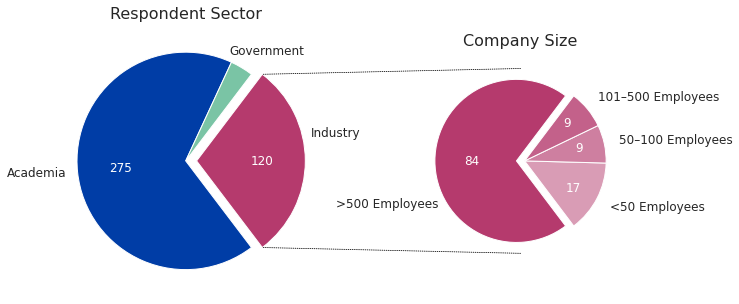

In [22]:
def figure1(df, output_folder, show = False):

    # Create a plot that will contain two pie charts within it
    fig, (ax0, ax1) = plt.subplots(ncols=2, figsize=(12, 5))
    fig.subplots_adjust(wspace=0)

    # Extract the relevant counts from the data
    counts = df.Sector.value_counts().tolist()[:-1]
    labels = df.Sector.value_counts().index.tolist()[:-1] 

    # Print the data that will be plotted
    if show: 
        print('Left hand plot values:')
        for lab, val in zip(labels, counts):
            print(f'{lab:<25s}{val}')
        print('——————————')

    # This caluclation finds the right starting angle to plot with, so that the middle of the industry slice lies on the horizontal axis
    angle = 360 * ((sum(counts[1:]) - 0.5 * counts[1]) / sum(counts))

    # Plot the left-hand pie chart, and save the returned matplotlib objects for the slices, the label texts, and the number texts on each slice
    wedges, text, autotexts = ax0.pie(counts, labels = labels, colors = colors, startangle = angle, autopct='',  # For now, don't add numbers on the slices
                                      explode = [0, 0.1, 0],  # The "industry" slice will be slightly pulled out of the center
                                      textprops = {'fontname': 'DejaVu Sans', 'fontsize': 12})

    # Manually adjust the locations of some of the labels so that they don't overlap
    text[1].set_y(0.25)
    text[1].set_x(1.15)
    text[2].set_y(1.01)
    text[2].set_x(0.4)

    # For academia and industry ONLY, add white numbers to the pie slices (the slices for government and other are too small)
    for a, c in zip(autotexts[:2], counts[:2]):
        a.set_text(f'{c}')
        a.set_color('white')


    # The right-hand side of the pie chart should consist of 4 different shades of the same red used to plot "industry" as a whole
    inset_colors = [to_rgba(colors[1], alpha = a) for a in reversed([1., 0.8, 0.65, 0.5])]

    # Extract the relevant counts and labels from the data
    labels = ['<50 Employees', '50-100 Employees', '101-500 Employees', '>500 Employees']
    counts = [len(df[(df.Sector == 'Industry') & (df.CompanySize == lab)]) for lab in labels]
    labels = ['<50 Employees', '50–100 Employees', '101–500 Employees', '>500 Employees']  # Updates the hyphens to n-dashes after finding the relevant counts

    # Print the data that will be plotted
    if show:
        print('Right hand plot values:')
        for lab, val in zip(labels, counts):
            print(f'{lab:<25s}{val}')

    # This calculation finds the right starting angle to plot with, such that the largest slice (>500 Employees) ends up facing left and horizontally aligned with the left-hand "industry" slice
    angle = -360 * 0.5 * sum(counts[:-1]) / sum(counts)

    # Plot the right-hand pie chart, and save the returned matplotlib objects for the slices, the label texts, and the number texts on each slice
    # This one is more difficult because we want three slices (the "small" company slices) to be exploded as a *single* slice, not to be exploded separately
    # To do this, we will first make a (white, non-visible) plot with each one exploded separately, but then manipulate the geometry of the slices and color them in
    wedges, text, autotexts = ax1.pie(counts, labels = labels, startangle = angle, colors = ['white'] * 4,  # Colors are initially white because we will readjust the geometry of these slices later
                                      explode = [.1,.1,.1,0],  # Ensure that all three of the "small" company items are exploded (these will be reformatted into a single exploded slice, below)
                                      textprops = {'fontname': 'DejaVu Sans', 'fontsize': 12}, autopct='',  # As before, leave numbers blank for now
                                      radius = 0.75)  # Make this pie chart smaller than the left-hand one

    # Manually adjust the locations of the ">500 Employees" label so that it doesn't overlap with a label from the left-hand graph
    text[3].set_y(-0.4)
    text[3].set_x(-0.75)

    # The white patches will be overwritten with slightly adjusted red patches, so move them to the back of the image 
    [w.set_zorder(-1) for w in wedges]


    # The following code groups the three small company slices together and manipulates the geometry of both groups
    groups = [[0,1,2], [3]]
    radfraction = 0.05
    patches = []
    for i in groups:
        ang = np.deg2rad((wedges[i[-1]].theta2 + wedges[i[0]].theta1)/2,)
        for j in i:
            we = wedges[j]
            center = (radfraction*we.r*np.cos(ang), radfraction*we.r*np.sin(ang))
            patches.append(mpatches.Wedge(center, we.r, we.theta1, we.theta2))

    # Create a patch collection object out of the geometrically adjusted slices, color them in, and add them to the right-hand plot
    collection = PatchCollection(patches, cmap = LinearSegmentedColormap.from_list('custom_map', inset_colors, N=4))
    collection.set_array(np.array([0,1,2,3]))
    ax1.add_collection(collection)

    # Add numerical labels to the slices in the right-hand plot in white font 
    for a, c in zip(autotexts, counts):
        a.set_text(f'{c}')
        a.set_color('white')


    # Drawing connecting lines
    theta1, theta2 = ax0.patches[1].theta1, ax0.patches[1].theta2
    center, r = ax0.patches[1].center, ax0.patches[1].r
    x = r * np.cos(np.pi / 180 * theta2) + center[0]
    y = np.sin(np.pi / 180 * theta2) + center[1]
    con = ConnectionPatch(xyA=(0, .85), xyB=(x, y),
                          coordsA="data", coordsB="data", axesA=ax1, axesB=ax0)
    con.set_color([0, 0, 0])
    con.set_linewidth(0.8)
    con.set_linestyle(':')
    ax1.add_artist(con)

    x = r * np.cos(np.pi / 180 * theta1) + center[0]
    y = np.sin(np.pi / 180 * theta1) + center[1]
    con = ConnectionPatch(xyA=(0, -0.85), xyB=(x, y), coordsA="data",
                          coordsB="data", axesA=ax1, axesB=ax0)
    con.set_color([0, 0, 0])
    con.set_linewidth(0.8)
    con.set_linestyle(':')
    ax1.add_artist(con)

    # Do some final visualization touch-up and save the figure 
    ax0.set_title('Respondent Sector', fontsize=16, fontname='DejaVu Sans')
    ax1.set_title('Company Size', fontsize=16, fontname='DejaVu Sans', y=.9)
    fig.savefig(f'../results/{output_folder}/Fig1.jpg', dpi=300, bbox_inches='tight')

    if show: plt.show()
    plt.close()
    

# Plot the results, display results for the non-snowball responses
figure1(df, 'figures', show = True)
figure1(all_responses, 'supplemental/with_snowball')
figure1(completed, 'supplemental/no_partial_responses')

              CV   NLP    RL  Robotics  Other
Academia    96.0  83.0  59.0      58.0  107.0
Industry    49.0  58.0  17.0      13.0   47.0
Government   6.0   2.0   4.0       1.0    6.0


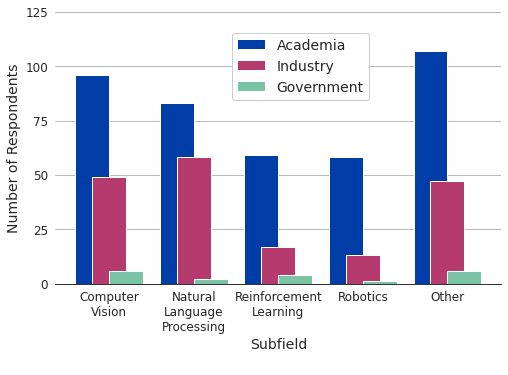

In [23]:
def figure2(df, output_folder, show = False):

    # Create a 3x5 matrix to hold the number of academics, industry researchers, and government researchers in each subfield, then loop over each possible combination
    # NOTE: this excludes the one person who responded to the subfield question but did not identify as either an academic, industry researchers, or governemnt researcher
    data = np.zeros((3, 5))
    for i, s in enumerate(['Academia', 'Industry', 'Government']):
        for j, f in enumerate(['CV', 'NLP', 'RL', 'Robotics', 'Other']):
            data[i,j] = df[df.Sector == s][f].sum()

    # Print the data being plotted
    data_df = pd.DataFrame({f: data[:, i] for i, f in enumerate(['CV', 'NLP', 'RL', 'Robotics', 'Other'])}, index = ['Academia', 'Industry', 'Government'])
    if show: print(data_df)

    # Initialize labels for plotting and create figure
    labels = ['Computer\nVision', 'Natural\nLanguage\nProcessing', 'Reinforcement\nLearning', 'Robotics', 'Other']
    fig, ax = plt.subplots(figsize=(8,5))

    # Add another layer to each of the five columns for all academics, then all industry researchers, then all government researchers and update the starting position for the next iteration
    for i, s in enumerate(['Academia', 'Industry', 'Government']):
        ax.bar(np.arange(5) - 0.2 + 0.2 * i, data[i], color=colors[i], label = s, width = 0.4)

    # Adjust figure aesthetics and labels
    ax.set_ylabel('Number of Respondents', fontsize=14, fontname='DejaVu Sans')
    ax.set_yticks(np.arange(0, 150, 25))
    ax.set_yticklabels([str(i) for i in np.arange(0, 150, 25)], fontsize=12, fontname='DejaVu Sans')
    ax.set_xticks(np.arange(5))
    ax.set_xticklabels(labels, fontsize=12, fontname='DejaVu Sans')
    ax.set_xlabel('Subfield\n', fontsize=14, fontname='DejaVu Sans')
    ax.legend(prop=basefont, loc='center', bbox_to_anchor = (0.55, 0.8))

    # Save and display the image
    plt.savefig(f'../results/{output_folder}/Fig2.jpg', dpi=300, bbox_inches='tight')

    if show: plt.show()
    plt.close()
    

# Plot the results, display results for the non-snowball responses
figure2(df, 'figures', show = True)
figure2(all_responses, 'supplemental/with_snowball')
figure2(completed, 'supplemental/no_partial_responses')

"Comparing reported AI fields for academic and industry affiliated respondents, a larger share of academics report working in robotics and reinforcement learning while among industry respondents, a large share report working in natural language processing. [FN: The larger proportion of NLP researchers in industry was significant by a chi-squared test of independence at p = 0.004 after applying a Bonferroni correction for repeated significance testing. Other differences between industry and academic makeup were not significant.]"

In [24]:
def test_field_diff(col_name):
    # Look only at the data from either academics or industry researchers
    subset = df[(df.Sector == 'Academia') | (df.Sector == 'Industry')]
    
    # Extract all the relevant values for the frequency table
    acad_no = sum((subset.Sector == 'Academia') & (subset[col_name] == 0))
    ind_no = sum((subset.Sector == 'Industry') & (subset[col_name] == 0))
    acad_yes = sum((subset.Sector == 'Academia') & (subset[col_name] == 1))
    ind_yes = sum((subset.Sector == 'Industry') & (subset[col_name] == 1))
    
    # Which sector is overrepresented? Then return the p-value (multiplied by 5 for Bonferroni correction)
    overrepresented_sector = 'Academia' if acad_yes / (acad_yes + acad_no) >= ind_yes / (ind_yes + ind_no) else 'Industry'
    return overrepresented_sector, min(1., chi2_contingency([[acad_yes, acad_no], [ind_yes, ind_no]])[1] * 5)
    

# Iterate over each major field with this test
for field in ['CV', 'Robotics', 'NLP', 'RL', 'Other']:
    print(f"{field}: {test_field_diff(field)[0]} is overrepresented with p = {test_field_diff(field)[1]}")

CV: Industry is overrepresented with p = 1.0
Robotics: Academia is overrepresented with p = 0.10744788249294326
NLP: Industry is overrepresented with p = 0.004059022172935588
RL: Academia is overrepresented with p = 0.6043870886955334
Other: Industry is overrepresented with p = 1.0


## Compute is not the primary constraint for many AI researchers

### Finding 1.1. Researchers report talent as the primary factor contributing to the success of their most significant projects. 

"Respondents were asked to share details about two projects they worked on in the previous five years: the project that they felt made the most significant contribution to research progress in their field (“most significant project”), and their most compute-intensive project. Interestingly, 67 percent of respondents reported that these two projects were the same."

In [25]:
# Show the breakdown by sector for percent indiating "same project" 
df.SameProject.value_counts(normalize = True)

1.0    0.674757
0.0    0.325243
Name: SameProject, dtype: float64

"Asked how important various factors were for their most significant project, 90 percent rated “specialized knowledge, talent, or skills” and 52 percent rated “large amounts of compute” as very or extremely important for the same project’s success, as shown in Figure 3 . . . A similar proportion (51 percent) rated “unique data” as very or extremely important."

                                            Proportion        CI
Unique Data                                   0.514493  0.048285
Size of Team                                  0.168675  0.036133
Specialized\nKnowledge, Talent,\nor Skills    0.896386  0.029407
Large Amounts\nof Compute                     0.516908  0.048277


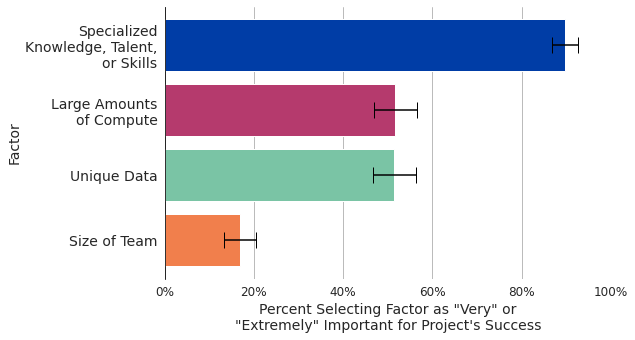

In [26]:
def figure3(df, output_folder, show = False):
    fig, ax = plt.subplots(figsize = (8,5))

    # Extract the proportion of respondents rating each factor as very or extremely important
    props, counts = np.zeros((4,)), np.zeros((4,))
    for i, col in enumerate(['Data', 'TeamSize', 'Talent', 'Compute']):
        counts[i] = len(df[~df[f'Success{col}'].isna()])
        props[i] = len(df[df[f'Success{col}'] >= 3]) / counts[i]

    # Use the equation 1.96 * sqrt( p * (1-p) / n ) to calculate the standard error for the sample, then calculate the confidence intervals
    cis = t.ppf(1 - 0.05/2, df = counts - 1) * np.sqrt(props * (1 - props) / counts)

    # Print the final data being plotted
    labels = ['Unique Data', 'Size of Team', 'Specialized\nKnowledge, Talent,\nor Skills', 'Large Amounts\nof Compute']
    data_df = pd.DataFrame({'Proportion': props, 'CI': cis}, index = labels)
    if show: print(data_df)

    # Plot the results on a bar chart and add error bars corresponding to the margins of error
    for x, i in enumerate(np.argsort(props)[::-1]):
        ax.barh(4 - x, props[i], color = colors[x], label = labels[i])
        ax.errorbar(props[i], 4 - x, xerr = cis[i], color='black', fmt='none')

    # Adjsut the aesthetics of the plot and save it
    ax.set_yticks([1,2,3,4])
    ax.set_yticklabels(np.array(labels)[np.argsort(props)], fontname='DejaVu Sans', fontsize=14)
    ax.set_ylabel('Factor', fontsize=14, fontname='DejaVu Sans')
    ax.set_xlabel('Percent Selecting Factor as "Very" or\n"Extremely" Important for Project\'s Success', 
                  fontsize=14, fontname='DejaVu Sans')
    ax.grid(False)
    ax.grid(axis='x')
    ax.spines['left'].set_visible(True)
    ax.spines['bottom'].set_visible(False)
    ax.set_xticks([0, 0.2, 0.4, 0.6, 0.8, 1.])
    ax.set_xticklabels(['0%', '20%', '40%', '60%', '80%', '100%'], fontsize=12, fontname='DejaVu Sans')
    plt.savefig(f'../results/{output_folder}/Fig3.jpg', dpi=300, bbox_inches='tight')

    if show: plt.show()
    plt.close()
    

# Plot the results, display results for the non-snowball responses
figure3(df, 'figures', show = True)
figure3(all_responses, 'supplemental/with_snowball')
figure3(completed, 'supplemental/no_partial_responses')

"Among respondents indicating that their most compute-intensive project was their most significant project, 62 percent indicated that compute was very or extremely important to the project’s success."

In [27]:
# Among resopndents saying significant project == compute-intensive project, calculate how many said compute was very/extremely important to the project
n = len(df[(df.SameProject == 1) & (~df.SuccessCompute.isna())])
len(df[(df.SameProject == 1) & (df.SuccessCompute >= 3)]) / n

0.6159420289855072

### Finding 1.2. Most researchers would prioritize talent if they had more funding.

"Roughly half (52 percent) said that they would first spend the additional money on either “hiring researchers” or “hiring more programmers or engineers,” which are binned together in Figure 4 under “Talent.”  About a fifth of researchers would make “purchasing more or higher-quality compute” their first priority and a similar share would first use the funds to collect or clean data."

            Proportion        CI
Talent        0.517401  0.047309
Data          0.215777  0.038945
Compute       0.204176  0.038163
Evaluation    0.062645  0.022942


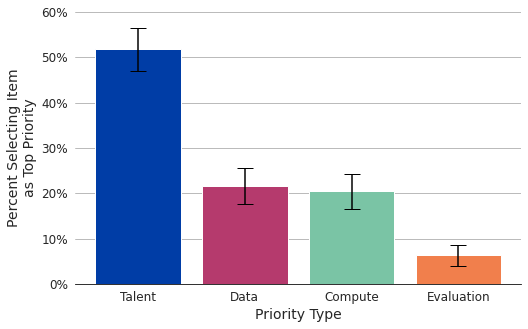

In [28]:
def figure4(df, output_folder, show = False):
    fig, ax = plt.subplots(figsize = (8,5))

    # Extract the proportion of respondents selecting each of the four binned options and calculate the confidence intervals for each
    props = np.array(df.PrioritySimplified.value_counts(normalize=True))
    n = df.PrioritySimplified.value_counts(dropna = True).sum()
    cis = t.ppf(1 - 0.05/2, df = n - 1) * np.sqrt(props * (1 - props) / df.PrioritySimplified.value_counts().sum())

    # Print the final data being plotted
    data_df = pd.DataFrame({'Proportion': props, 'CI': cis}, index = df.PrioritySimplified.value_counts().index)
    if show: print(data_df)

    # Plot the results on a bar chart and add error bars corresponding to the margins of error
    for i in range(4):
        ax.bar(i, props[i], width=0.8, color=colors[i])
    ax.errorbar(np.arange(4), props, yerr=cis, color='black', fmt='none')

    # Adjsut the aesthetics of the plot and save it
    ax.set_xticks(np.arange(4))
    ax.set_xticklabels(df.PrioritySimplified.value_counts().index, fontsize=12, fontname='DejaVu Sans')
    ax.set_xlabel('Priority Type', fontsize=14, fontname='DejaVu Sans')
    ax.set_ylabel('Percent Selecting Item\nas Top Priority', fontsize=14, fontname='DejaVu Sans')
    ax.set_yticks([0.0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6])
    ax.set_yticklabels(['0%', '10%', '20%', '30%', '40%', '50%', '60%'], fontsize=12, fontname='DejaVu Sans')
    plt.savefig(f'../results/{output_folder}/Fig4.jpg', dpi=300, bbox_inches='tight')

    if show: plt.show()
    plt.close()
    
# Plot the results, display results for the non-snowball responses
figure4(df, 'figures', show = True)
figure4(all_responses, 'supplemental/with_snowball')
figure4(completed, 'supplemental/no_partial_responses')

### Finding 1.3. When researchers are forced to change their research plans, it is more often due to talent or data limitations than compute limitations.

"All pairwise comparisons were made using Mann-Whitney U tests with 3-way Bonferroni correction. Differences between compute and data were significant for rejecting, revising, and abandoning projects (all p < 0.001). Differences between compute and researcher availability were significant for rejecting and abandoning projects (both p < 0.001) but not for revising projects (p = 0.773). Differences between data and researcher availability were significant for revising projects (p = 0.038) but not for rejecting (p = 1.0) or abandoning projects (p = 0.497)."

In [29]:
# Create a dataframe for significance results
sig_df = pd.DataFrame({'Compute/Data': [1.] * 3, 'Compute/Researcher': [1.] * 3, 'Data/Researcher': [1.] * 3}, 
                        index = ['Reject', 'Revise', 'Abandon'])

# Iterate over each possible pairwise comparison of factors
for c in combinations(['Compute', 'Data', 'Researcher'], 2):
    
    # And then iterate over each of the three hypothetical scenarios
    for scenario in sig_df.index:

        # Calculate the Mann-Whitney U value
        subset = df[(~df[f'{c[0]}{scenario}'].isna()) & (~df[f'{c[1]}{scenario}'].isna())]
        mwu = mannwhitneyu(subset[f'{c[0]}{scenario}'], subset[f'{c[1]}{scenario}'])

        # Save the result and multiply by 3 for Bonferroni correction
        sig_df.loc[scenario, f'{c[0]}/{c[1]}'] = min(1., mwu[1] * 3)

# Print the results
print(sig_df)

         Compute/Data  Compute/Researcher  Data/Researcher
Reject   2.032935e-10        7.160189e-11         1.000000
Revise   6.428997e-04        7.733551e-01         0.038319
Abandon  2.815304e-09        2.888872e-13         0.496722


Means:
             Reject  Revise  Abandon
Compute      1.993   2.579    1.593
Data         2.518   2.867    2.019
Researcher   2.538   2.676    2.126 
Confidence Intervals:
             Reject  Revise  Abandon
Compute      0.103   0.110    0.081
Data         0.114   0.113    0.101
Researcher   0.116   0.114    0.105


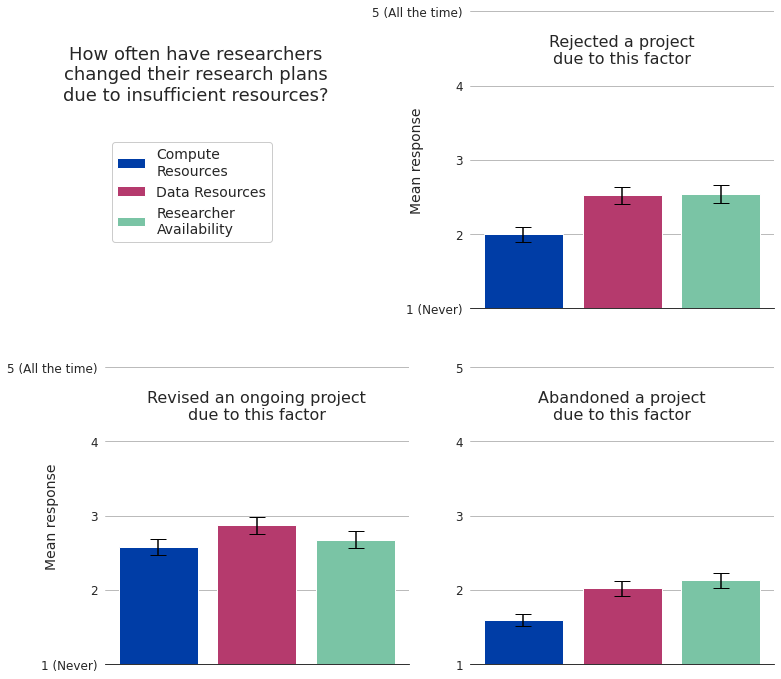

In [30]:
def figure5(df, output_folder, show = False):
    # Create a two-by-two grid of subplots (the top left grid will only contain a legend)
    fig, axes = plt.subplots(ncols=2, nrows=2, figsize=(12,12))

    # Create a dataframe to save mean values to as they are calculated and confidence intervals
    data_df = pd.DataFrame({'Reject': [0.] * 3, 'Revise': [0.] * 3, 'Abandon': [0.] * 3}, index = ['Compute', 'Data', 'Researcher'])
    cis_df = pd.DataFrame({'Reject': [0.] * 3, 'Revise': [0.] * 3, 'Abandon': [0.] * 3}, index = ['Compute', 'Data', 'Researcher'])

    # Iterate over each of the three axes object, each of which refers to a different hypothetical situation
    for i, (ax, situation) in enumerate(zip([axes[0][1], axes[1][0], axes[1][1]], ['Reject', 'Revise', 'Abandon'])):
        cols = [f'Compute{situation}', f'Data{situation}', f'Researcher{situation}']
        labs = ['Compute\nResources', 'Data Resources', 'Researcher\nAvailability']

        # For each factor, plot a single bar on the relevant axis showing the mean values (plus 1, since our data is stored in the range [0,4] but we want to plot in the range [1,5])
        for j, (col, lab) in enumerate(zip(cols, labs)):
            ax.bar(j, df[col].mean() + 1., color=colors[j], label=lab)

            # Also calculate and plot margins of error using the equation 1.96 * std / sqrt(n)
            n = len(df[col].dropna())
            error = t.ppf(1 - 0.05/2, df = n - 1) * df[col].std() / np.sqrt(n)
            ax.errorbar(j, df[col].mean() + 1., yerr = error, color = 'black', fmt = 'none')

            # Also update the dataframes of final results
            data_df.loc[lab.split()[0], situation] = round(df[col].mean() + 1., 3)
            cis_df.loc[lab.split()[0], situation] = round(error, 3)

        # Set the appropriate y-scale and remove xticks
        ax.set_ylim([1.,5.])
        ax.set_yticks(np.arange(1,6))
        ax.set_yticklabels([str(n) for n in np.arange(1, 6)], fontsize=12, fontname='DejaVu Sans')
        ax.set_xticks([])

    # For the top-right and bottom-left axes, adjust the labels of the y-ticks to show the range of responses
    for ax in ([axes[0][1], axes[1][0]]):
        ax.set_yticklabels(['1 (Never)', '2', '3', '4', '5 (All the time)'], fontsize=12, fontname='DejaVu Sans')
        ax.set_ylabel('Mean response', fontsize=14, fontname='DejaVu Sans')
        ax.yaxis.set_label_coords(-.15, .5)

    # Add annotations to each plot showing which hypothetical situation it represents
    for ax, lab in zip([axes[0][1], axes[1][0], axes[1][1]], 
                       ['Rejected a project', 'Revised an ongoing project', 'Abandoned a project']):
        ax.annotate(f'{lab}\ndue to this factor', xy=(1., 4.3), ha='center', fontsize=16, fontname='DejaVu Sans')


    # Adjust the top-left subplot so that it contains a legend and a question describing the results
    handles, labels = axes[0][1].get_legend_handles_labels()
    axes[0][0].legend(handles, labels, prop=basefont, loc=3, bbox_to_anchor=(0., 0.2))
    axes[0][0].grid(False)
    axes[0][0].axis(False)
    axes[0][0].annotate('How often have researchers\nchanged their research plans\ndue to insufficient resources?',
                       xy=(0.3, 0.7), xycoords='axes fraction', ha='center', fontsize=18, fontname='DejaVu Sans')

    # Print the full array of means
    if show: print('Means:\n', data_df, '\nConfidence Intervals:\n', cis_df)

    # Save the final result
    plt.savefig(f'../results/{output_folder}/Fig5.jpg', dpi=300, bbox_inches='tight')

    if show: plt.show()
    plt.close()
    
# Plot the results, display results for the non-snowball responses
figure5(df, 'figures', show = True)
figure5(all_responses, 'supplemental/with_snowball')
figure5(completed, 'supplemental/no_partial_responses')

The following cell block redoes the analysis of the previous block, but in a different layout.

Means:
             Reject  Revise  Abandon
Compute      1.993   2.579    1.593
Data         2.518   2.867    2.019
Researcher   2.538   2.676    2.126 
Confidence Intervals:
             Reject  Revise  Abandon
Compute      0.103   0.110    0.081
Data         0.114   0.113    0.101
Researcher   0.116   0.114    0.105


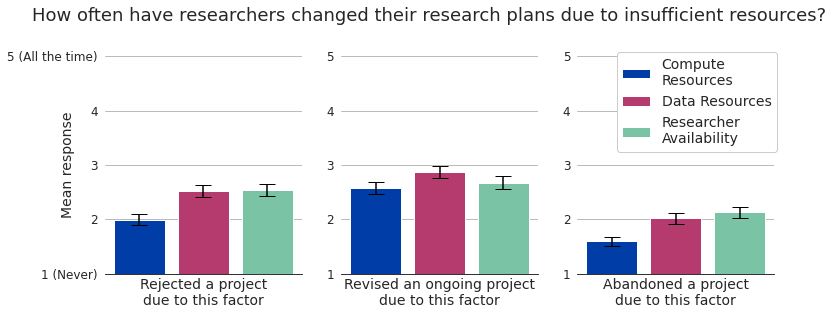

In [31]:
def figure5_v2(df, output_folder, show = False):
    # Create a plot with three sub-grids for the results
    fig, axes = plt.subplots(ncols=3, figsize=(12,4))

    # Create a dataframe to save mean values to as they are calculated and confidence intervals
    data_df = pd.DataFrame({'Reject': [0.] * 3, 'Revise': [0.] * 3, 'Abandon': [0.] * 3}, index = ['Compute', 'Data', 'Researcher'])
    cis_df = pd.DataFrame({'Reject': [0.] * 3, 'Revise': [0.] * 3, 'Abandon': [0.] * 3}, index = ['Compute', 'Data', 'Researcher'])

    # Iterate over each of the three axes object, each of which refers to a different hypothetical situation
    for i, (ax, situation) in enumerate(zip(axes, ['Reject', 'Revise', 'Abandon'])):
        cols = [f'Compute{situation}', f'Data{situation}', f'Researcher{situation}']
        labs = ['Compute\nResources', 'Data Resources', 'Researcher\nAvailability']

        # For each factor, plot a single bar on the relevant axis showing the mean values (plus 1, since our data is stored in the range [0,4] but we want to plot in the range [1,5])
        for j, (col, lab) in enumerate(zip(cols, labs)):
            ax.bar(j, df[col].mean() + 1., color=colors[j], label=lab)

            # Also calculate and plot margins of error using the equation 1.96 * std / sqrt(n)
            n = len(df[col].dropna())
            error = t.ppf(1 - 0.05/2, df = n - 1) * df[col].std() / np.sqrt(n)
            ax.errorbar(j, df[col].mean() + 1., yerr = error, color = 'black', fmt = 'none')

            # Also update the dataframes of final results
            data_df.loc[lab.split()[0], situation] = round(df[col].mean() + 1., 3)
            cis_df.loc[lab.split()[0], situation] = round(error, 3)

        # Set the appropriate y-scale and remove xticks
        ax.set_ylim([1.,5.])
        ax.set_yticks(np.arange(1,6))
        ax.set_yticklabels([str(n) for n in np.arange(1, 6)], fontsize=12, fontname='DejaVu Sans')
        ax.set_xticks([])

    # For the left-most panel, adjust the labels of the y-ticks to show the range of responses
    axes[0].set_yticklabels(['1 (Never)', '2', '3', '4', '5 (All the time)'], fontsize=12, fontname='DejaVu Sans')
    axes[0].set_ylabel('Mean response', fontsize=14, fontname='DejaVu Sans')
    axes[0].yaxis.set_label_coords(-.15, .5)

    # Add labels to each plot showing which hypothetical situation it represents
    for ax, lab in zip(axes, ['Rejected a project', 'Revised an ongoing project', 'Abandoned a project']):
        ax.set_xlabel(f'{lab}\ndue to this factor', fontsize=14, fontname='DejaVu Sans')

    # Adjust the right-most subplot so that it contains a legend and a question describing the results
    handles, labels = axes[2].get_legend_handles_labels()
    axes[2].legend(handles, labels, prop=basefont, loc=1, bbox_to_anchor=(1.05, 1.05))
    fig.suptitle('How often have researchers changed their research plans due to insufficient resources?', fontsize=18, fontname='DejaVu Sans', y=1.05)

    # Print the full array of means
    if show: print('Means:\n', data_df, '\nConfidence Intervals:\n', cis_df)

    # Save the final result
    plt.savefig(f'../results/{output_folder}/Fig5_v2.jpg', dpi=300, bbox_inches='tight')

    if show: plt.show()
    plt.close()
    
# Plot the results, display results for the non-snowball responses
figure5_v2(df, 'figures', show = True)
figure5_v2(all_responses, 'supplemental/with_snowball')
figure5_v2(completed, 'supplemental/no_partial_responses')

"While lack of data and talent are more often reported as reasons for rejecting or abandoning a project, 76 percent of respondents report revising projects due to insufficient compute at least sometimes over the last two years."

In [32]:
print('Percent NEVER revising projects due to a lack of compute:', 
      round(100 * len(df[df.ComputeRevise == 0]) / len(df.ComputeRevise.dropna()), 2), '%')
print('Percent SOMETIMES revising projects due to a lack of compute:', 
      round(100 * len(df[df.ComputeRevise > 0]) / len(df.ComputeRevise.dropna()), 2), '%')

Percent NEVER revising projects due to a lack of compute: 23.73 %
Percent SOMETIMES revising projects due to a lack of compute: 76.27 %


"We did, however, find that 43 percent of respondents reported never rejecting a project due to insufficient compute, which indicates that some subset of AI researchers are able to pursue the research they want at their current level of compute resourcing.[FN: While academic respondents more frequently report rejecting a project due to a lack of compute (p=0.029 by a Mann-Whitney U test), 39 percent of academics say that they never rejected a project due to insufficient compute.]"

In [33]:
# Print out the overall frequency of answers
print(df.ComputeReject.value_counts())

# And also print out the percentages 
print(df.ComputeReject.value_counts(normalize = True))

0.0    179
1.0    105
2.0     90
3.0     31
4.0      8
Name: ComputeReject, dtype: int64
0.0    0.433414
1.0    0.254237
2.0    0.217918
3.0    0.075061
4.0    0.019370
Name: ComputeReject, dtype: float64


In [34]:
# Check whether the responses from academics and industry are significantly different
print(mannwhitneyu(df[df.Sector == 'Academia'].ComputeReject.dropna(), df[df.Sector == 'Industry'].ComputeReject.dropna()))

# Print the mean response for academia and industry, separately
print('Mean for academia:', df[df.Sector == 'Academia'].ComputeReject.mean())
print('Mean for industry:', df[df.Sector == 'Industry'].ComputeReject.mean())

MannwhitneyuResult(statistic=18445.5, pvalue=0.02861899811385533)
Mean for academia: 1.0912408759124088
Mean for industry: 0.8403361344537815


In [35]:
# Print out the overall frequency of answers (for academia)
print(df[df.Sector == 'Academia'].ComputeReject.value_counts())

# And also print out the percentages (for academia)
print(df[df.Sector == 'Academia'].ComputeReject.value_counts(normalize = True))

0.0    108
1.0     70
2.0     65
3.0     25
4.0      6
Name: ComputeReject, dtype: int64
0.0    0.394161
1.0    0.255474
2.0    0.237226
3.0    0.091241
4.0    0.021898
Name: ComputeReject, dtype: float64


### Finding 1.4. Most respondents think computing’s role in driving AI progress will stay the same or decrease in the next decade, compared to its role in the past decade.  

"There was general agreement that each factor contributed to AI progress over this period, with 59 percent indicating strong agreement that past AI progress was the result of more compute—higher agreement than any other factor."

In [36]:
# Create arrays to hold the number agreeing or strongly agreeing for each factor, and total responses
agreement = []
strong_agreement = []
total = []

# Loop over each factor and caluclate the relevant values
for factor in ['Compute', 'Data', 'Algorithms', 'Researchers', 'Support']:
    total.append(len(df[~df[f'Past{factor}'].isna()]))
    agreement.append(len(df[df[f'Past{factor}'] >= 3.]))
    strong_agreement.append(len(df[df[f'Past{factor}'] >= 4.]))
    
# Format the results into a dataframe and print it out
agreement_rates = pd.DataFrame({'Factor': ['Compute', 'Data', 'Algorithms', 'Researchers', 'Support'],
                               'Agreeing': agreement, 'Strongly Agreeing': strong_agreement, 'Total Responses': total, 
                               'Percent Agreeing': 100 * np.array(agreement) / np.array(total), 
                               'Percent Strongly Agreeing': 100 * np.array(strong_agreement) / np.array(total)})
print(agreement_rates)

        Factor  Agreeing  Strongly Agreeing  Total Responses  \
0      Compute       379                242              412   
1         Data       351                195              411   
2   Algorithms       319                126              410   
3  Researchers       316                131              410   
4      Support       322                136              411   

   Percent Agreeing  Percent Strongly Agreeing  
0         91.990291                  58.737864  
1         85.401460                  47.445255  
2         77.804878                  30.731707  
3         77.073171                  31.951220  
4         78.345499                  33.090024  


"Compared to 59 percent of respondents who indicated strong agreement that more compute was a past driver of AI progress, fewer (40 percent) strongly agreed that more compute would drive future AI progress. One factor increased in strong agreement among respondents—better algorithms. 31 percent strongly agreed it was a driver of past AI progress, but 53 percent strongly agreed that it would drive future progress—the highest jump in agreement among the factors."

In [37]:
# Create arrays to hold the number agreeing or strongly agreeing for each factor, and total responses
agreement = []
strong_agreement = []
total = []

# Loop over each factor and caluclate the relevant values
for factor in ['Compute', 'Data', 'Algorithms', 'Researchers', 'Support']:
    total.append(len(df[~df[f'Future{factor}'].isna()]))
    agreement.append(len(df[df[f'Future{factor}'] >= 3.]))
    strong_agreement.append(len(df[df[f'Future{factor}'] >= 4.]))
    
# Format the results into a dataframe and print it out
agreement_rates = pd.DataFrame({'Factor': ['Compute', 'Data', 'Algorithms', 'Researchers', 'Support'],
                               'Agreeing': agreement, 'Strongly Agreeing': strong_agreement, 'Total Responses': total, 
                               'Percent Agreeing': 100 * np.array(agreement) / np.array(total), 
                               'Percent Strongly Agreeing': 100 * np.array(strong_agreement) / np.array(total)})
print(agreement_rates)

        Factor  Agreeing  Strongly Agreeing  Total Responses  \
0      Compute       319                164              410   
1         Data       336                179              410   
2   Algorithms       352                217              410   
3  Researchers       287                144              409   
4      Support       322                171              410   

   Percent Agreeing  Percent Strongly Agreeing  
0         77.804878                  40.000000  
1         81.951220                  43.658537  
2         85.853659                  52.926829  
3         70.171149                  35.207824  
4         78.536585                  41.707317  


Note on Table 1: "Asterisks indicate statistically significant differences (p < 0.001) as calculated by a Mann-Whitney U test with Bonferroni correction comparing last decade to next decade responses." 

In [38]:
# Use a Mann-Whitney U test for each and multiply the p-value by 5 to apply Bonferroni correction
for factor in ['Compute', 'Algorithms', 'Researchers', 'Data', 'Support']:
    p = min(1., mannwhitneyu(df[f'Past{factor}'].dropna(), df[f'Future{factor}'].dropna())[1] * 5)
    sig = 'IS' if p < 0.05 else 'IS NOT'
    print(f'The difference between past and future assessments of the importance of {factor.lower()} {sig} significant at p = {p}')

The difference between past and future assessments of the importance of compute IS significant at p = 1.0587449518855559e-09
The difference between past and future assessments of the importance of algorithms IS significant at p = 3.600528039345832e-09
The difference between past and future assessments of the importance of researchers IS NOT significant at p = 1.0
The difference between past and future assessments of the importance of data IS NOT significant at p = 0.7785023739864954
The difference between past and future assessments of the importance of support IS NOT significant at p = 0.36722392698581585


## Reported compute use is similar for industry and academia

### Finding 2.1. Academics report paying less for compute but do not report significantly less compute use.  

"When asked how expensive the total compute required by this project was, academics reported spending significantly less than industry researchers, as shown in Figure 6 . . . When asked about compute use for this same project in terms of GPU hours, however, we observe no meaningful difference, also shown in Figure 6. [FN: Difference in distribution for reported compute use in dollars between the two groups is statistically significant with p < 0.001 by a Mann-Whitney U test. The difference between the two groups for reported compute use in GPU hours is not statistically significant by a Mann-Whitney U test (p = 0.225).]"

In [39]:
# First, do a simple significance test on both the CompGPUs and CompCost fields using a Mann-Whitney U test
print(mannwhitneyu(df[df.Sector == 'Academia'].CompCost.dropna(), df[df.Sector == 'Industry'].CompCost.dropna()))
print(mannwhitneyu(df[df.Sector == 'Academia'].CompGPUs.dropna(), df[df.Sector == 'Industry'].CompGPUs.dropna()))

MannwhitneyuResult(statistic=3523.0, pvalue=1.551789411442718e-05)
MannwhitneyuResult(statistic=9383.0, pvalue=0.2249061744430071)


Reported Cost Proportions
                    Academia  Industry
$0                  0.117647  0.033898
$1-1,000            0.133690  0.067797
$1,001-10,000       0.331551  0.220339
$10,001-$100,000    0.310160  0.322034
$100,001-1,000,000  0.074866  0.254237
>$1,000,000         0.032086  0.101695
——————————
Reported GPU Hour Proportions
                Academia  Industry
None            0.092105  0.088889
<50             0.131579  0.088889
51-500          0.219298  0.266667
501-5,000       0.311404  0.222222
5,001-50,000    0.171053  0.155556
50,000-500,000  0.065789  0.133333
>500,000        0.008772  0.044444


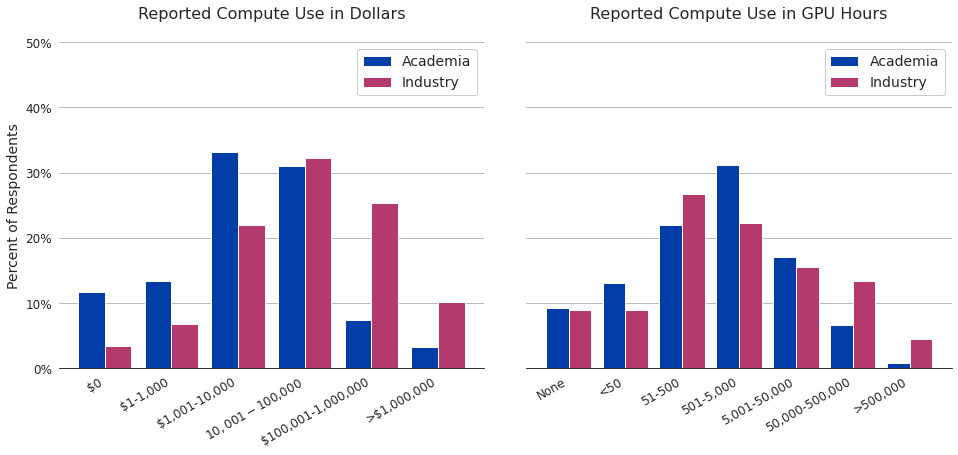

In [40]:
def figure6(df, output_folder, show = False):
    # Create a figure with two subplots, where the left hand side will show the differences in costs and the right hand side will show differences in GPU-hours used
    fig, (ax0, ax1) = plt.subplots(ncols=2, sharey=True, figsize=(16, 6))

    # List out the labels corresponding to different answers
    left_labs = ['$0', '$1-1,000', '$1,001-10,000', '$10,001-$100,000', '$100,001-1,000,000', '>$1,000,000']
    right_labs = ['None', '<50', '51-500', '501-5,000', '5,001-50,000', '50,000-500,000', '>500,000']

    # Plot the data for reported cost for both academia and industry
    ax0.bar(np.arange(len(left_labs)) - 0.2, df[df.Sector == 'Academia'].CompCost.value_counts(normalize=True).sort_index().tolist(), 
           width = 0.4, color=colors[0], label='Academia')
    #NOTE: There are zero responses from industry for the lowest cost threshold 
    ax0.bar(np.arange(len(left_labs)) + 0.2, df[df.Sector == 'Industry'].CompCost.value_counts(normalize=True).sort_index().tolist(), 
           width = 0.4, color=colors[1], label='Industry')

    # Print out the results
    if show: 
        print('Reported Cost Proportions')
        print(pd.DataFrame({'Academia': df[df.Sector == 'Academia'].CompCost.value_counts(normalize=True).sort_index().tolist(),
                     'Industry': df[df.Sector == 'Industry'].CompCost.value_counts(normalize=True).sort_index().tolist()}, index = left_labs))

    # Adjust the aesthetics of the left-hand plot and add an annotation indicating the significance result
    ax0.set_xticks(np.arange(len(left_labs)))
    ax0.set_xticklabels(left_labs, rotation=30, ha='right', fontsize=12, fontname='DejaVu Sans')
    ax0.set_ylim([0,0.38])
    ax0.set_yticks([0,0.1,0.2,0.3,0.4,0.5])
    ax0.set_yticklabels(['0%', '10%', '20%', '30%', '40%', '50%'], fontsize=12, fontname='DejaVu Sans')
    ax0.set_ylabel('Percent of Respondents', fontsize=14, fontname='DejaVu Sans')
    ax0.set_title('Reported Compute Use in Dollars\n', fontsize=16, fontname='DejaVu Sans')
    ax0.legend(prop=basefont)

    # Plot the data for reported GPU-hours for both academia and industry
    ax1.bar(np.arange(len(right_labs)) - 0.2, df[df.Sector == 'Academia'].CompGPUs.value_counts(normalize=True).sort_index().tolist(), 
           width = 0.4, color=colors[0], label='Academia')
    ax1.bar(np.arange(len(right_labs)) + 0.2, df[df.Sector == 'Industry'].CompGPUs.value_counts(normalize=True).sort_index().tolist(), 
           width = 0.4, color=colors[1], label='Industry')

    # Print out the data 
    if show: 
        print('——————————\nReported GPU Hour Proportions')
        print(pd.DataFrame({'Academia': df[df.Sector == 'Academia'].CompGPUs.value_counts(normalize=True).sort_index().tolist(),
                 'Industry': df[df.Sector == 'Industry'].CompGPUs.value_counts(normalize=True).sort_index().tolist()}, index = right_labs))

    # Adjsut the aesthetics of the right-hand plot and add a legend to the right of the graph itself
    ax1.set_xticks(np.arange(len(right_labs)))
    ax1.set_xticklabels(right_labs, rotation=30, ha='right', fontsize=12, fontname='DejaVu Sans')
    ax1.set_title('Reported Compute Use in GPU Hours\n', fontsize=16, fontname='DejaVu Sans')
    ax1.set_yticks([0,0.1,0.2,0.3,0.4,0.5])
    ax1.legend(prop=basefont)

    # Adjust space between the two grids and save the figure
    fig.subplots_adjust(wspace=0.1)
    plt.savefig(f'../results/{output_folder}/Fig6.jpg', dpi=300, bbox_inches='tight')

    if show: plt.show()
    plt.close()
    

# Plot the results, display results for the non-snowball responses
figure6(df, 'figures', show = True)
figure6(all_responses, 'supplemental/with_snowball')
figure6(completed, 'supplemental/no_partial_responses')

"First, 349 respondents provided information about GPU hours, compared to only 278 respondents for cost.[FN: Note that 18 percent of industry researchers and 9 percent of academics did not report compute use by either metric.]"

In [41]:
# Print out total responses for the two questions
print('Responses for cost:', len(df[~df.CompCost.isna()]))
print('Responses for GPU hours:', len(df[~df.CompGPUs.isna()]))
print('Respondents who DID finish the survey but did NOT answer either question:', 
    len(df[(df.Finished == 1) & (df.CompCost.isna()) & (df.CompGPUs.isna())]))

# Print out response rates by question and sector
for sector in ['Academia', 'Industry']:
    total = len(df[df.Sector == sector])
    for question in ['Cost', 'GPUs']:
        responses = len(df[(df.Sector == sector) & (~df[f'Comp{question}'].isna())])
        print(f'Response rate for {sector} and {question} is {round(100 * responses / total, 2)}%')

    # Also calculate and print out non-response rate by sector
    non_responses = len(df[(df.Sector == sector) & (df.CompCost.isna()) & (df.CompGPUs.isna())])
    print(f'Non-response rate for {sector} is {round(100 * non_responses / total, 2)}%')

Responses for cost: 278
Responses for GPU hours: 349
Respondents who DID finish the survey but did NOT answer either question: 49
Response rate for Academia and Cost is 68.0%
Response rate for Academia and GPUs is 82.91%
Non-response rate for Academia is 8.73%
Response rate for Industry and Cost is 49.17%
Response rate for Industry and GPUs is 75.0%
Non-response rate for Industry is 18.33%


"[FN: Among academics, 82 percent reported using on-premise compute (46 percent reported using exclusively on-premise compute), and 52 percent of industry researchers reported using on-premise compute (22 percent exclusively). The differences in the proportions of both on-premise compute users and exclusive on-premise compute users between academic and industry respondents were statistically significant by a chi-squared test of independence at p < 0.001.]"

In [42]:
# Create arrays to hold raw totals for on-premise users and exclusive on-premise users
onprem = []
exclusive = []
total = []

# Extract relevant counts and totals for both academia and industry
for sector in ['Academia', 'Industry']:
    total.append(len(df[(df.Sector == sector) & (~df.OnPremise.isna()) & (~df.CloudUser.isna())]))
    onprem.append(len(df[(df.Sector == sector) & (df.OnPremise == 1) & (~df.CloudUser.isna())]))
    exclusive.append(len(df[(df.Sector == sector) & (df.OnPremise == 1) & (df.CloudUser == 0)]))

# Format these values as a dataframe and print it out
onprem_users = pd.DataFrame({'On-Premise User': onprem, 'On-Premise ONLY': exclusive, 'Total': total, 'Percent On-Premise': 100 * np.array(onprem) / np.array(total), 
                            'Percent On-Premise ONLY': 100 * np.array(exclusive) / np.array(total)}, index = ['Academia', 'Industry'])
print(onprem_users)

# Also verify that these differences between industry and academia are statistically significant using a chi-squared test
print('p-value to reject independence of sector and any on-premise use:', chi2_contingency([
    [onprem_users.loc['Academia', 'On-Premise User'], onprem_users.loc['Academia', 'Total'] - onprem_users.loc['Academia', 'On-Premise User']],
    [onprem_users.loc['Industry', 'On-Premise User'], onprem_users.loc['Industry', 'Total'] - onprem_users.loc['Industry', 'On-Premise User']]
])[1])
print('p-value to reject independence of sector and exclusive on-premise use:', chi2_contingency([
    [onprem_users.loc['Academia', 'On-Premise ONLY'], onprem_users.loc['Academia', 'Total'] - onprem_users.loc['Academia', 'On-Premise ONLY']],
    [onprem_users.loc['Industry', 'On-Premise ONLY'], onprem_users.loc['Industry', 'Total'] - onprem_users.loc['Industry', 'On-Premise ONLY']]
])[1])

          On-Premise User  On-Premise ONLY  Total  Percent On-Premise  \
Academia              225              127    274           82.116788   
Industry               61               26    118           51.694915   

          Percent On-Premise ONLY  
Academia                46.350365  
Industry                22.033898  
p-value to reject independence of sector and any on-premise use: 1.085372960684956e-09
p-value to reject independence of sector and exclusive on-premise use: 1.0138948112214513e-05


### Finding 2.2. Academics cite salary and benefits as an important consideration for leaving academia more often than compute resources.

"When asked if they ever considered leaving academia for an AI-related role in industry, 65 percent of academic respondents answered yes, underscoring the risk of universities losing researchers to private industry."

In [43]:
# Print out the counts of people answering yes about leaving academia
df[df.Sector == 'Academia'].ConsideredLeaving.value_counts(dropna = False, normalize = True)

1.0    0.647273
0.0    0.352727
Name: ConsideredLeaving, dtype: float64

"Among academics who answered yes, 70 percent cited salary and/or benefits as a very or extremely important factor in considering leaving academia, as shown in Figure 7. The factors least often rated as very or extremely important were compute or data resources, with 35 percent and 28 percent of researchers rating them as very or extremely important, respectively."

                     Proportions  Confidence Intervals
LeavingSalary           0.702247              0.067638
LeavingContribution     0.466292              0.073790
LeavingProjects         0.359551              0.070981
LeavingCompute          0.353933              0.070732
LeavingData             0.275281              0.066068


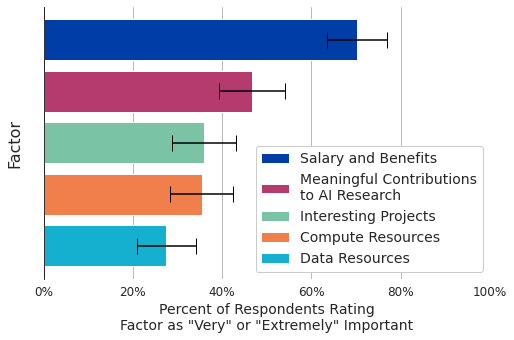

In [44]:
def figure7(df, output_folder, show = False):
    fig, ax = plt.subplots(figsize=(8,5))

    # Create an array to hold the proportions of academics for each factor rating that factor as "very" or "extremely" important 
    factors = ['LeavingSalary', 'LeavingData', 'LeavingCompute', 'LeavingProjects', 'LeavingContribution']
    props = np.zeros(5,)
    n = np.zeros(5,)
    for i, lab in enumerate(factors):
        n[i] = len(df.dropna(subset = [lab]))
        props[i] = len(df[df[lab] >= 3.]) / n[i]

    # Calculate confidence intervals using the same method as previously
    cis = t.ppf(1 - 0.05/2, df = n - 1) * np.sqrt(props * (1-props) / n)

    # Print out the data
    if show: print(pd.DataFrame({'Proportions': props[np.argsort(props)[::-1]], 
                       'Confidence Intervals': cis[np.argsort(props)[::-1]]}, 
                       index = np.array(factors)[np.argsort(props)[::-1]]))

    # Plot the data for each factor in a different color and label it
    labels = ['Salary and Benefits', 'Data Resources', 'Compute Resources', 'Interesting Projects', 'Meaningful Contributions\nto AI Research']
    for i, (p, ci, lab) in enumerate(zip(props[np.argsort(props)[::-1]], cis[np.argsort(props)[::-1]], np.array(labels)[np.argsort(props)[::-1]])):
        ax.barh(5-i, p, color=colors[i], label=lab)
        ax.errorbar(p, 5-i, xerr=ci, color='black', fmt='none')

    # Adjust aesthetics, add title and legend
    ax.set_xlabel('Percent of Respondents Rating\nFactor as \"Very\" or \"Extremely\" Important', fontsize=14, fontname='DejaVu Sans')
    ax.set_xlim([0,1])
    ax.set_xticks([0.,0.2,0.4,0.6,0.8,1.])
    ax.set_xticklabels(['0%', '20%', '40%', '60%', '80%', '100%'], fontsize=12, fontname='DejaVu Sans')
    ax.set_yticks([])
    ax.set_ylabel('Factor\n', fontsize=16, fontname='DejaVu Sans')
    ax.grid(axis='x')
    ax.spines['left'].set_visible(True)
    ax.spines['bottom'].set_visible(False)
    ax.legend(prop=basefont, loc=4)

    # Save the figure
    fig.savefig(f'../results/{output_folder}/Fig7.jpg', dpi=300, bbox_inches='tight')

    if show: plt.show()
    plt.close()
    

# Plot the results, display results for the non-snowball responses
figure7(df, 'figures', show = True)
figure7(all_responses, 'supplemental/with_snowball')
figure7(completed, 'supplemental/no_partial_responses')

### Finding 2.3. Academics report compute needs have outpaced availability but are not significantly more concerned about future access impacting their contributions to AI.

"We observe a significantly greater proportion of respondents in academia report that their change in compute needs has exceeded their change in compute access, as compared to respondents in industry.[FN: To determine this, we constructed a contingency table representing the number of respondents in both academia and industry either 1) reporting greater growth in compute needs than compute access (column 1 of Figure 8) or 2) reporting greater growth in compute access than compute needs or reporting the same value for both (columns 2 and 3 of Figure 7). By a chi-squared test of independence, academics were significantly more likely to report growth in compute needs that was not matched by growth in compute access (p = 0.004).]"

In [45]:
# Create a function to determine whether a respondent reported MORE growth in compute needs than access (-1), LESS growth in needs than access (1), or the same (0)
def return_sign(x):
    if x['NeedChanges'] == x['AccessChanges']:
        return 0
    elif x['NeedChanges'] > x['AccessChanges']:
        return -1
    else: return 1
    

# Calculate the number of respondents for different categories
def calc_num_responses(sector, list_of_vals):
    subset = df[(df.Sector == sector) & (~df.NeedChanges.isna()) & (~df.AccessChanges.isna())].copy()

    # Again use return_sign() to create a new column "NeedVsAccess"
    subset['NeedVsAccess'] = subset.apply(return_sign, axis = 1)

    # Return the number of respondents falling into the relevant category, based on the column NeedVsAccess
    return len(subset[subset.NeedVsAccess.isin(list_of_vals)])


# Use a chi-squared test to compare the number indicating needs greater than access (NeedVsAccess.isin([-1])) to the number indicating 
# otherwise (NeedVsAccess.isin([0, 1])) for both academia and industry
chi2_contingency([
    [calc_num_responses('Academia', [-1]), calc_num_responses('Academia', [0, 1])], 
    [calc_num_responses('Industry', [-1]), calc_num_responses('Industry', [0, 1])]
])

Chi2ContingencyResult(statistic=8.304441637397753, pvalue=0.003954823914829898, dof=1, expected_freq=array([[ 98.86075949, 176.13924051],
       [ 43.13924051,  76.86075949]]))

Proportions:
           Needs > Access  Needs == Access  Needs < Access
Academia        0.407273         0.480000        0.112727
Industry        0.250000         0.533333        0.216667 
Confidence Intervals:
           Needs > Access  Needs == Access  Needs < Access
Academia        0.058328         0.059310        0.037545
Industry        0.078270         0.090178        0.074467


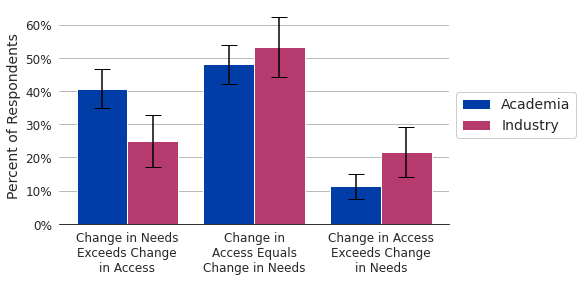

In [46]:
# Create another helper function to calculate the percent falling into each category in a sector
def calc_percent(subset, sector, val):

    # This references a new column in the data that will be created within function8() using return_sign()
    n = len(subset[(subset.Sector == sector) & (~subset.NeedVsAccess.isna())])
    pct = len(subset[(subset.Sector == sector) & (subset.NeedVsAccess == val)]) / n
    
    # Also calculate a confidence interval using the equation 1.96 * sqrt( p * (1-p) / n )
    ci = t.ppf(1 - 0.05/2, df = n - 1) * np.sqrt(pct * (1 - pct) / n)
    return pct, ci


# Create a function to actual plot the graph itself given input data
def figure8(df, output_folder, show = False):
    
    # The subset of data is researchers in either academia or industry who answered both NeedChanges and AccessChanges
    subset = df[(~df.NeedChanges.isna()) & (~df.AccessChanges.isna())].copy()
    subset = subset[(subset.Sector == 'Academia') | (subset.Sector == 'Industry')]

    # Create a new column with values of -1, 0, and 1 corresponding to the nature of respondent's answers
    subset['NeedVsAccess'] = subset.apply(return_sign, axis = 1)

    # Create dataframes to save results
    data_df = pd.DataFrame({'Needs > Access': [0.] * 2, 'Needs == Access': [0.] * 2, 'Needs < Access': [0.] * 2}, index = ['Academia', 'Industry'])
    cis_df = pd.DataFrame({'Needs > Access': [0.] * 2, 'Needs == Access': [0.] * 2, 'Needs < Access': [0.] * 2}, index = ['Academia', 'Industry'])

    # Loop over the various values and fill in the dataframes
    for i, label in zip([-1, 0, 1], ['Needs > Access', 'Needs == Access', 'Needs < Access']):
        for sector in ['Academia', 'Industry']:
            data_df.loc[sector, label] = calc_percent(subset, sector, i)[0]
            cis_df.loc[sector, label] = calc_percent(subset, sector, i)[1]

    # Print out the results
    if show: print('Proportions:\n', data_df, '\nConfidence Intervals:\n', cis_df)

    # Create the figure
    fig, ax = plt.subplots(figsize = (7, 4))

    # Plot the results
    for i, sector in enumerate(['Academia', 'Industry']):
        ax.bar(np.arange(3) - 0.2 + i * 0.4, data_df.loc[sector], color = colors[i], label = sector, width = 0.4)
        ax.errorbar(np.arange(3) - 0.2 + i * 0.4, data_df.loc[sector], yerr = cis_df.loc[sector], color = 'black', fmt = 'none')

    # Adjust figure aesthetics 
    ax.legend(loc='center left', bbox_to_anchor=(1, 0.5), prop=basefont)
    ax.set_xticks([0, 1, 2])
    ax.set_xticklabels(['Change in Needs\nExceeds Change\nin Access', 'Change in\nAccess Equals\nChange in Needs', 
                    'Change in Access\nExceeds Change\nin Needs'], fontname = 'DejaVu Sans', fontsize = 12)
    ax.set_ylabel('Percent of Respondents', fontname = 'DejaVu Sans', fontsize = 14)
    ax.set_yticks([0.0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6])
    ax.set_yticklabels(['0%', '10%', '20%', '30%', '40%', '50%', '60%'], fontsize=12, fontname='DejaVu Sans')

    # Save the final figure
    plt.savefig(f'../results/{output_folder}/Fig8.jpg', dpi = 300, bbox_inches = 'tight')
        
    # Display the figure
    if show: plt.show()
    plt.close()


# Plot the results, display results for the non-snowball responses
figure8(df, 'figures', show = True)
figure8(all_responses, 'supplemental/with_snowball')
figure8(completed, 'supplemental/no_partial_responses')

"Academics were slightly more likely to report being “moderately” or “extremely” concerned, but those differences are not significant.[FN: A Mann-Whitney U test results in a p-value of 0.123.]"

In [47]:
# First use a Mann-Whitney U test to evaluate whether the two distributions are statistically different
mannwhitneyu(df[df.Sector == 'Academia'].ContributionConcern.dropna(), df[df.Sector == 'Industry'].ContributionConcern.dropna())

MannwhitneyuResult(statistic=18075.0, pvalue=0.12286871395901691)

                      Academia  Industry
Not at all concerned  0.189091  0.266667
Slightly concerned    0.189091  0.208333
Somewhat concerned    0.210909  0.158333
Moderately concerned  0.261818  0.233333
Extremely concerned   0.149091  0.133333


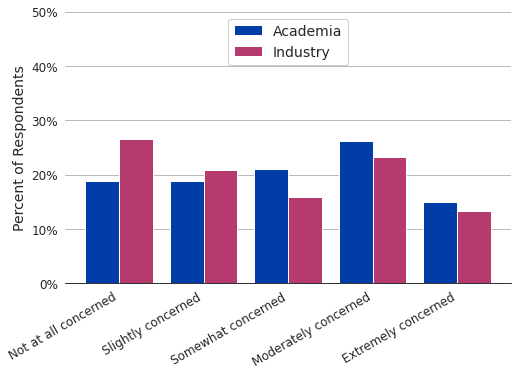

In [48]:
def figure9(df, output_folder, show = False):
    fig, ax = plt.subplots(figsize=(8, 5))

    # Assign labels for each response
    labels = ['Not at all concerned', 'Slightly concerned', 'Somewhat concerned', 'Moderately concerned', 'Extremely concerned']

    # Plot the data
    ax.bar(np.arange(len(labels)) - 0.2, df[df.Sector == 'Academia'].ContributionConcern.value_counts(normalize=True).sort_index().tolist(), 
           width = 0.4, color=colors[0], label='Academia')
    ax.bar(np.arange(len(labels)) + 0.2, df[df.Sector == 'Industry'].ContributionConcern.value_counts(normalize=True).sort_index().tolist(), 
           width = 0.4, color=colors[1], label='Industry')

    # Print out the data
    if show: print(pd.DataFrame({'Academia': df[df.Sector == 'Academia'].ContributionConcern.value_counts(normalize=True).sort_index().tolist(),
                       'Industry': df[df.Sector == 'Industry'].ContributionConcern.value_counts(normalize=True).sort_index().tolist()},
                       index = labels))

    # Adjust figure aesthetics, add title and axis labels, and add a legend
    ax.set_xticks(np.arange(len(labels)))
    ax.set_xticklabels(labels, rotation=30, ha='right', fontsize=12, fontname='DejaVu Sans')
    ax.set_ylim([0,0.35])
    ax.set_yticks([0.0, 0.1, 0.2, 0.3, 0.4, 0.5])
    ax.set_yticklabels(['0%', '10%', '20%', '30%', '40%', '50%'], fontsize=12, fontname='DejaVu Sans')
    ax.set_ylabel('Percent of Respondents', fontsize=14, fontname='DejaVu Sans')
    ax.legend(prop=basefont, loc=9)

    # Save the figure
    plt.savefig(f'../results/{output_folder}/Fig9.jpg', dpi=300, bbox_inches='tight')

    if show: plt.show()
    plt.close()
    

# Plot the results, display results for the non-snowball responses
figure9(df, 'figures', show = True)
figure9(all_responses, 'supplemental/with_snowball')
figure9(completed, 'supplemental/no_partial_responses')

### Finding 2.4. Higher compute use correlates with being more concerned about compute. 

Means by GPU Hours Used in Most Compute-Intensive Project
              Academia  Industry
<50           1.392157  1.000000
51–500        2.120000  1.500000
501–5,000     2.112676  2.800000
5,001–50,000  2.435897  1.928571
>50,000       2.823529  1.687500
——————————
Confidence Intervals by GPU Hours Used in Most Compute-Intensive Project
              Academia  Industry
<50           0.351640  0.674024
51–500        0.347547  0.597170
501–5,000     0.338423  0.470471
5,001–50,000  0.399065  0.973136
>50,000       0.581564  0.746483


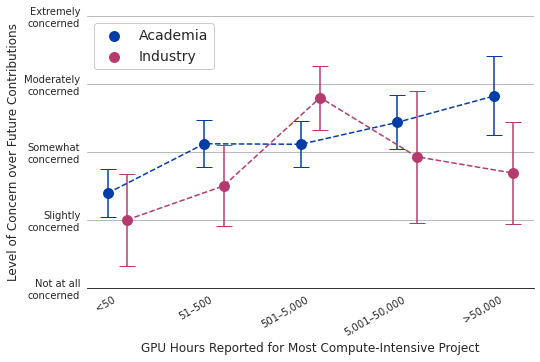

In [49]:
def figure10(df, output_folder, show = False):
    # Create arrays that will hold, for both academia and for industry, and for each level of compute usage, the number of respondents, the mean level of contribution concern,
    # and the standard deviation in the reported levels of contribution concern
    n = np.zeros((2,5))
    means = np.zeros((2,5))
    stds = np.zeros((2,5))

    # Fill in the arrays, while binning the bottom two and the top two GPU categories (due to low sample size)
    buckets = [[0,1], [2], [3], [4], [5,6]]
    for i, sector in enumerate(['Academia', 'Industry']):
        n[i] = [len(df[(df.Sector == sector) & (df.CompGPUs.isin(j)) & (~df.ContributionConcern.isna())]) for j in buckets]
        means[i] = [df[(df.Sector == sector) & (df.CompGPUs.isin(j))].ContributionConcern.mean() for j in buckets]
        stds[i] = [df[(df.Sector == sector) & (df.CompGPUs.isin(j))].ContributionConcern.std() for j in buckets]

    # Calculate margins of error using the equation 1.96 * std / sqrt(n)
    errors = t.ppf(1 - 0.05/2, df = n - 1) * stds / np.sqrt(n)

    # Print out the calculated data
    labels = ['<50', '51–500', '501–5,000', '5,001–50,000', '>50,000']
    if show: 
        print('Means by GPU Hours Used in Most Compute-Intensive Project')
        print(pd.DataFrame({'Academia': means[0], 'Industry': means[1]}, index=labels))
        print('——————————\nConfidence Intervals by GPU Hours Used in Most Compute-Intensive Project')
        print(pd.DataFrame({'Academia': errors[0], 'Industry': errors[1]}, index=labels))

    # Create the plot
    fig, ax = plt.subplots(figsize=(8,5))

    # Plot the results
    for i, (mean, err, lab) in enumerate(zip(means, errors, ['Academia', 'Industry'])):
        ax.errorbar(np.arange(len(labels)) - 0.1 + 0.2 * i, mean, yerr=err, ecolor=colors[i], fmt='--', color=colors[i])
        ax.scatter(np.arange(len(labels)) - 0.1 + 0.2 * i, mean, s=80, facecolors=colors[i], edgecolors=colors[i], linewidths=2, label=lab)

    # Adjust figure aesthetics, add axis captions and title, add legend, and save the figure
    y_labels = ['Not at all\nconcerned', 'Slightly\nconcerned', 'Somewhat\nconcerned', 'Moderately\nconcerned', 'Extremely\nconcerned']
    ax.set_ylim([0.,4.])
    ax.set_yticks(range(5))
    ax.set_yticklabels(y_labels, fontsize=10, rotation=0, ha='right', fontname='DejaVu Sans')
    ax.set_xticks(np.arange(len(labels)))
    ax.set_xticklabels(labels, fontsize=10, rotation=30, ha='right', fontname='DejaVu Sans')
    ax.set_ylabel('Level of Concern over Future Contributions', fontsize=12, fontname='DejaVu Sans')
    ax.set_xlabel('GPU Hours Reported for Most Compute-Intensive Project', fontsize=12, fontname='DejaVu Sans')
    ax.legend(prop=basefont)
    plt.savefig(f'../results/{output_folder}/Fig10.jpg', dpi=300, bbox_inches='tight')

    if show: plt.show()
    plt.close()
    

# Plot the results, display results for the non-snowball responses
figure10(df, 'figures', show = True)
figure10(all_responses, 'supplemental/with_snowball')
figure10(completed, 'supplemental/no_partial_responses')

"Box 1: Correlation between reported compute usage and compute attitudes and behaviors
Respondents who reported using greater amounts of compute in their most compute-intensive project also tended to give higher responses on each of the following indicators: <br/>
<ul>
    <li>Frequency of abandoning projects due to insufficient compute (ρ = 0.11)</li>
    <li>Frequency of revising projects due to insufficient compute (ρ = 0.27)</li>
    <li>Frequency of rejecting projects due to insufficient compute (ρ = 0.28)</li>
    <li>Importance assigned to a lack of compute as a reason to consider leaving academia (ρ = 0.33)</li>
    <li>Level of agreement that compute was a major driver of AI progress over the last decade (ρ = 0.19)</li>
    <li>Level of agreement that compute will be a major driver of AI progress over the next decade (ρ = 0.17)</li>
</ul>
[FN: We report Spearman’s rank correlation. The p-values for the six indicators discussed here were 0.045, &lt;0.001, &lt;0.001, &lt;0.001, 0.001, and 0.003, respectively. These values were calculated based on a permutation test with 10,000 samples. The correlation between compute use and importance assigned to a lack of compute as a reason to consider leaving academia includes only responses from academics; all other correlations include respondents from all sectors.]"

In [50]:
# permutation_test requires a callable calculation of the spearman's rho 
def statistic(x, y): 
    return spearmanr(x, y).statistic

# Create a function to examine the correlations between GPU utilization and several indicators of concern about compute
def calc_spearmans_rho(dep_var):
    subset = df[(~df.CompGPUs.isna()) & (~df[dep_var].isna())]

    # Extract the relevant data and calculate the spearman's rho
    x, y = subset.CompGPUs, subset[dep_var]

    # Use a permutation test to calculate the corresponding p-value 
    # (As recommended by https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.spearmanr.html)
    p_val = permutation_test((x, y), statistic, permutation_type = 'pairings', n_resamples = 10000, random_state = 42).pvalue

    # Return the results
    return statistic(x, y), p_val


# Create a dataframe to store the results of all permutation tests and their corresponding p-values
data_df = pd.DataFrame({'Spearman\'s rho': [0.] * 7, 'p-value': [0.] * 7}, 
                        index = ['ComputeAbandon', 'ComputeRevise', 'ComputeReject', 'LeavingCompute', 'PastCompute', 'FutureCompute', 'WantsCompute'])

# Loop over the variables of interest and calculate the rho/p-value for all respondents, only industry, and only academia
for dep_var in data_df.index:
    rho, p_val = calc_spearmans_rho(dep_var)
    data_df.loc[dep_var, 'Spearman\'s rho'] = rho
    data_df.loc[dep_var, 'p-value'] = p_val

# Print out the results
print(data_df)

/Users/micahmusser/opt/anaconda3/lib/python3.9/site-packages/scipy/stats/_resampling.py:992: RuntimeWarning: overflow encountered in double_scalars
  n_max = factorial(n_obs_sample)**n_samples


                Spearman's rho   p-value
ComputeAbandon        0.109890  0.044596
ComputeRevise         0.272104  0.000200
ComputeReject         0.284669  0.000200
LeavingCompute        0.325095  0.000200
PastCompute           0.191401  0.001000
FutureCompute         0.165650  0.002600
WantsCompute          0.151406  0.005399


# Researchers Have a Variety of Opinions About the NAIRR

            WantsData  WantsCompute  WantsStaff  WantsGrants  WantsStandards
Academia          149           184         108          249              73
Industry           79            78          31           69              43
Government         10             6           9            7               8


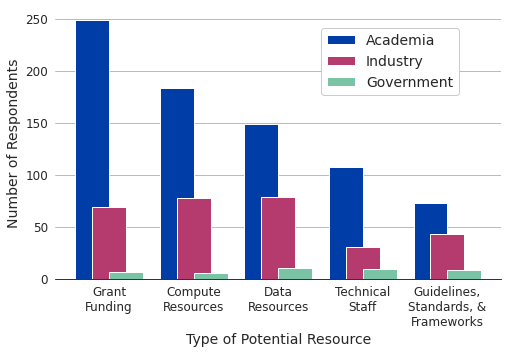

In [51]:
def figure11(df, output_folder, show = False):
    # Create an array to hold the data
    data = pd.DataFrame({'WantsData': [0, 0, 0], 'WantsCompute': [0, 0, 0], 
                         'WantsStaff': [0, 0, 0], 'WantsGrants': [0, 0, 0], 
                         'WantsStandards': [0, 0, 0]}, 
                        index=['Academia', 'Industry', 'Government'])

    # Fill in and print out the dataframe
    for col in data.columns:
        for sector in data.index:
            data.loc[sector, col] = df[df.Sector == sector][col].sum()
    if show: print(data)

    # Calculate totals and sort the data
    totals = np.sum(np.array(data), axis=0)
    sorted_data = np.array(data)[:, np.argsort(totals)[::-1]]

    # Initialize labels for plotting and create figure
    fig, ax = plt.subplots(figsize=(8,5))

    # Add another layer to each of the five columns for all academics, then all industry researchers, then all government researchers and update the starting position for the next iteration
    for i, s in enumerate(['Academia', 'Industry', 'Government']):
        ax.bar(np.arange(5) - 0.2 + 0.2 * i, sorted_data[i], color=colors[i], label = s, width = 0.4)

    # Adjust figure aesthetics and labels
    labels = ['Grant\nFunding', 'Compute\nResources', 'Data\nResources', 'Technical\nStaff', 'Guidelines,\nStandards, &\nFrameworks']
    ax.set_ylabel('Number of Respondents', fontsize=14, fontname='DejaVu Sans')
    ax.set_yticks(np.arange(0, 300, 50))
    ax.set_yticklabels([str(i) for i in np.arange(0, 300, 50)], fontsize=12, fontname='DejaVu Sans')
    ax.set_xticks(np.arange(5))
    ax.set_xticklabels(labels, fontsize=12, fontname='DejaVu Sans')
    ax.set_xlabel('Type of Potential Resource', fontsize=14, fontname='DejaVu Sans')
    ax.legend(prop=basefont, loc='center', bbox_to_anchor = (0.75, 0.8))

    # Save and display the image
    plt.savefig(f'../results/{output_folder}/Fig11.jpg', dpi=300, bbox_inches='tight')

    if show: plt.show()
    plt.close()
    

# Plot the results, display results for the non-snowball responses
figure11(df, 'figures', show = True)
figure11(all_responses, 'supplemental/with_snowball')
figure11(completed, 'supplemental/no_partial_responses')

# Specific Research Demographics May Vary in Compute Needs

"Defining high compute users as those who report using more than 5,000 GPU hours (n=94) we find these researchers are more inclined to want compute resources from the federal government. In fact, 67 respondents in this group want government-provided compute, compared to only 38 low compute users (those who report using 50 or fewer GPU hours, n=74).  More high compute users work in CV or in NLP, while low compute users more often work in other subfields, like recommender systems or algorithmic and architectural analysis."

In [52]:
# Create a function which, given a population of high compute users and one of low compute users, will perform the relevant calculations
def compare_high_and_low(high_compute_users, low_compute_users):

    # Print out the n for both populations
    print(f"There are {len(high_compute_users)} high compute users (>5000 GPU hours).")
    print(f"There are {len(low_compute_users)} low compute users (<=50 GPU hours).", '\n----------\n')

    # For each potential federal resource asked about, count how many respondents wanted that resource (as a raw count and a percentage)
    for want in ["WantsCompute", "WantsData", "WantsStaff", "WantsGrants", "WantsStandards"]:
        n_high = len(high_compute_users[high_compute_users[want] == 1])
        n_low = len(low_compute_users[low_compute_users[want] == 1])
        print(f"{n_high} high compute users want {want[5:].lower()} and {n_low} low compute users want {want[5:].lower()}")
        print(f"{(n_high/len(high_compute_users))*100:.2f}% of high compute users want {want[5:].lower()} and {(n_low/len(low_compute_users))*100:.2f}% of low compute users want {want[5:].lower()}")
        print()
    print('----------\n')

    # For each field, assess how many high and low compute users are in that field (as a raw count and a percentage)
    for field in ["CV", "NLP", "Robotics", "RL", "Other"]:
        n_high = len(high_compute_users[high_compute_users[field] == 1])
        n_low = len(low_compute_users[low_compute_users[field] == 1])
        print(f"The # of high compute users in {field} is {n_high} and the # of low compute users is {n_low}")
        print(f"The % of high compute users in {field} is {(n_high/len(high_compute_users))*100:.2f}% and the % of low compute users is {(n_low/len(low_compute_users))*100:.2f}%")
        print()
    print("----------\n")

    # Then do the same for each subfield that falls under the "Other" heading
    for subfield in ["RecommenderSystems", "Speech", "TimeSeriesData", "MusicAndAudio", "GraphAnalysis", "AlgorithmicOrArchitectureAnalysis", "NoneofThese"]:
        n_high = len(high_compute_users[high_compute_users[subfield] == 1])
        n_low = len(low_compute_users[low_compute_users[subfield] == 1])
        print(f"The # of high compute users in {subfield} is {n_high} and the # of low compute users is {n_low}")
        print(f"The % of high compute users in {subfield} is {(n_high/len(high_compute_users))*100:.2f}% and the % of low compute users is {(n_low/len(low_compute_users))*100:.2f}%")
        print()
    print("-----------\n")

    # Do the same while comparing the makeup of industry and academia among high and low compute users
    for sector in ["Academia", "Industry"]:
        n_high = len(high_compute_users[high_compute_users.Sector == sector])
        n_low = len(low_compute_users[low_compute_users.Sector == sector])
        print(f"The # of high compute users in {sector} is {n_high} and the # of low compute users is {n_low}")
        print(f"The % of high compute users in {sector} is {(n_high/len(high_compute_users))*100:.2f}% and the % of low compute users is {(n_low/len(low_compute_users))*100:.2f}%")
        print(f"The % of {sector} respondents among high compute users is {(n_high/len(df[df.Sector == sector]))*100:.2f}% and the % of {sector} respondents among low compute users is {(n_low/len(df[df.Sector == sector]))*100:.2f}%")
        print()
    print("\n----------\n")

    # Finally, repeat the previous step while looking only at the very highest tier of compute usage
    highest_compute_users = df[df.CompGPUs >= 6]
    for sector in ["Academia", "Industry"]:
      print(f"The # of highest compute users in {sector} is {len(highest_compute_users[highest_compute_users.Sector == sector])}")
      print(f"The % of {sector} respondents among highest compute users is {(len(highest_compute_users[highest_compute_users.Sector == sector])/len(df[df.Sector == sector]))*100:.2f}%")

In [53]:
# Bin the top three tiers of GPU users (based on CompGPUs) into a df for "high compute users" and the bottom two tiers into one for "low compute users"
high_compute_users = df[df.CompGPUs >= 4]
low_compute_users = df[df.CompGPUs <= 1]

# Use the previous function to calculate the relevant values
compare_high_and_low(high_compute_users, low_compute_users)

There are 94 high compute users (>5000 GPU hours).
There are 74 low compute users (<=50 GPU hours). 
----------

67 high compute users want compute and 38 low compute users want compute
71.28% of high compute users want compute and 51.35% of low compute users want compute

50 high compute users want data and 35 low compute users want data
53.19% of high compute users want data and 47.30% of low compute users want data

32 high compute users want staff and 21 low compute users want staff
34.04% of high compute users want staff and 28.38% of low compute users want staff

68 high compute users want grants and 54 low compute users want grants
72.34% of high compute users want grants and 72.97% of low compute users want grants

28 high compute users want standards and 22 low compute users want standards
29.79% of high compute users want standards and 29.73% of low compute users want standards

----------

The # of high compute users in CV is 45 and the # of low compute users is 7
The % of h

"We get similar results if cost in dollars is used to define high and low compute users rather than GPU hours. Other desired resources are selected at similar rates between high and low compute users . . . When we distinguish high and low compute users by cost in dollars, as opposed to GPU usage, we see a more equal proportion of NLP respondents in both groups, with roughly a quarter of both the highest and lowest spending respondents reporting working in NLP."

In [54]:
# Define two new populations of high and low compute users based on cost and rerun the previous cell
high_cost_users = df[df.CompCost >= 4]
low_cost_users = df[df.CompCost <= 1]

# Use the previous function to calculate the relevant values
compare_high_and_low(high_cost_users, low_cost_users)

There are 49 high compute users (>5000 GPU hours).
There are 62 low compute users (<=50 GPU hours). 
----------

33 high compute users want compute and 30 low compute users want compute
67.35% of high compute users want compute and 48.39% of low compute users want compute

26 high compute users want data and 31 low compute users want data
53.06% of high compute users want data and 50.00% of low compute users want data

19 high compute users want staff and 18 low compute users want staff
38.78% of high compute users want staff and 29.03% of low compute users want staff

31 high compute users want grants and 46 low compute users want grants
63.27% of high compute users want grants and 74.19% of low compute users want grants

17 high compute users want standards and 17 low compute users want standards
34.69% of high compute users want standards and 27.42% of low compute users want standards

----------

The # of high compute users in CV is 21 and the # of low compute users is 11
The % of 

"Comparing preferences of high and low compute users, we find fewer (8) low compute users would prioritize additional compute if afforded a larger budget, compared to high compute users (24). Low compute users are less concerned about compute constraining their ability to make future contributions to the field, with 27 respondents out of 74 not at all concerned, compared to only 13 out of 94 high compute users who are not at all concerned. These results reflect our earlier finding that researchers who use more compute tend to be more concerned about future access to compute. This again suggests that the goal of democratizing AI research by making more compute available to all researchers could actually stratify existing differences in use if only high compute users make use of it."

In [55]:
# Analyze the number and percent of low and high compute users (still based on GPU-hours) prioritizing each type of resource
for priority in ["Compute", "Talent", "Data"]:
    n_high = len(high_compute_users[high_compute_users.PrioritySimplified == priority])
    pct_high = n_high / len(high_compute_users[~high_compute_users.PrioritySimplified.isna()])
    n_low = len(low_compute_users[low_compute_users.PrioritySimplified == priority])
    pct_low = n_low / len(low_compute_users[~low_compute_users.PrioritySimplified.isna()])
    print(f"The # of high compute users who would prioritize {priority} is {n_high} ({round(100 * pct_high, 2)}%) and the # of low compute users is {n_low} ({round(100 * pct_low, 2)}%)")
print("\n----------\n")

# Then analyze the number and percent of respondents attributing their project success to each factor ("very" or "extremely" important)
for success in ["SuccessData", "SuccessTeamSize", "SuccessTalent", "SuccessCompute"]:
    n_high = len(high_compute_users[high_compute_users[success] >= 3])
    pct_high = n_high / len(high_compute_users[~high_compute_users[success].isna()])
    n_low = len(low_compute_users[low_compute_users[success] >= 3])
    pct_low = n_low / len(low_compute_users[~low_compute_users[success].isna()])
    print(f"The # of high compute users who attribute their success to {success[7:].lower()} is {n_high} ({round(100 * pct_high, 2)}%) and the # of low compute users is {n_low} ({round(100 * pct_low, 2)}%)")
print("\n----------\n")

# Finally, analyze the percent of high and low compute users at each tier of concern level over future contributions being limited by insufficient compute
for i, concern_level in enumerate(["not at all concerned", "slightly_concerned", "somewhat concerned", "moderately concerned", "extremely concerned"]):
    n_high = len(high_compute_users[high_compute_users.ContributionConcern == i])
    n_low = len(low_compute_users[low_compute_users.ContributionConcern == i])
    print(f"The # of high compute users whose concern level is {concern_level.replace('_', ' ')} is {n_high} and the # of low compute users is {n_low}")
    print(f"The % of high compute users whose concern level is {concern_level.replace('_', ' ')} is {(n_high/len(high_compute_users))*100:.2f}% and the % of low compute users is {(n_low/len(low_compute_users))*100:.2f}%")
    print()

The # of high compute users who would prioritize Compute is 24 (25.53%) and the # of low compute users is 8 (11.11%)
The # of high compute users who would prioritize Talent is 50 (53.19%) and the # of low compute users is 41 (56.94%)
The # of high compute users who would prioritize Data is 16 (17.02%) and the # of low compute users is 17 (23.61%)

----------

The # of high compute users who attribute their success to data is 41 (47.13%) and the # of low compute users is 24 (35.82%)
The # of high compute users who attribute their success to teamsize is 19 (21.84%) and the # of low compute users is 7 (10.29%)
The # of high compute users who attribute their success to talent is 79 (90.8%) and the # of low compute users is 60 (88.24%)
The # of high compute users who attribute their success to compute is 60 (68.97%) and the # of low compute users is 27 (40.3%)

----------

The # of high compute users whose concern level is not at all concerned is 13 and the # of low compute users is 27
The 

"Just under half of our respondents who reported working in NLP (n=143) also reported working on language modeling (n=70). In both industry and academia, roughly half of NLP researchers reported working on language modeling (n=70)."

In [56]:
# Create dataframes of subset populations for NLP researchers, language modelers, and NLP researchers who do not do language modeling
nlpers = df[df.NLP == 1]
language_modelers = df[df.LanguageModeling == 1]
non_model_nlpers = df[(df.LanguageModeling) == 0 & (df.NLP == 1)]

# Print out the size of each of these populations
print(f"There are {len(nlpers)} NLP respondents.")
print(f"There are {len(language_modelers)} language modeling respondents.")
print(f"There are {len(non_model_nlpers)} NLP respondents who report that they do not do language modeling.")
print("\n----------\n")

# Print out the composition of each population based on sector
for sector in ["Academia", "Industry"]:
  print(f"The # of language modelers in {sector} is {len(language_modelers[language_modelers.Sector == sector])} while the # of NLP respondents is {len(nlpers[nlpers.Sector == sector])} and the # of non-language-model NLPers is {len(non_model_nlpers[non_model_nlpers.Sector == sector])}")
  print(f"The % of {sector} respondents among language modelers is {(len(language_modelers[language_modelers.Sector == sector])/len(language_modelers))*100:.2f}% while the % among NLP respondents is {(len(nlpers[nlpers.Sector == sector])/len(nlpers))*100:.2f}%")
  print()

There are 143 NLP respondents.
There are 70 language modeling respondents.
There are 70 NLP respondents who report that they do not do language modeling.

----------

The # of language modelers in Academia is 40 while the # of NLP respondents is 83 and the # of non-language-model NLPers is 42
The % of Academia respondents among language modelers is 57.14% while the % among NLP respondents is 58.04%

The # of language modelers in Industry is 28 while the # of NLP respondents is 58 and the # of non-language-model NLPers is 28
The % of Industry respondents among language modelers is 40.00% while the % among NLP respondents is 40.56%



"Language modelers and other NLP researchers reported similar compute use, except on the extremes, where more language modelers reported the highest compute usage and no language modelers report the lowest compute usage. There are ten language modelers in the two highest use categories (GPU-hours > 50,000), as compared to only four non-language modeler NLP researchers, so these researchers represent a tiny fraction of all researchers surveyed. While our sample size for this specific population was too small to make general claims about language modelers’ views on compute, other survey research has identified interesting divisions among NLP researchers and further research could address this more explicitly."

In [57]:
# Print out the number of researchers at each tier of GPU usage for both language modelers and all NLP researchers (as both counts and percentages)
for i, computeuse in enumerate(["no", "50 or fewer", "51-500", "501-5000", "5001-50,000", "50,001-500,000", "more than 500,000"]):
    print(f"The # of language modelers who report using {computeuse} GPUs is {len(language_modelers[language_modelers.CompGPUs == i])} while the # of NLP respondents is {len(nlpers[nlpers.CompGPUs == i])} and the # of non-language-model NLPers is {len(non_model_nlpers[non_model_nlpers.CompGPUs == i])}")
    print(f"The % of language modelers who report using {computeuse} GPUs is {(len(language_modelers[language_modelers.CompGPUs == i])/len(language_modelers))*100:.2f}% while the % of NLP respondents is {(len(nlpers[nlpers.CompGPUs == i])/len(nlpers))*100:.2f}%")
    print()
print("-----\n")

# Do the same for all tiers of cost usage
for i, computeuse in enumerate(["$0", "$1-$1000", "$1,001-$10,000", "$10,001-$100,000", "$100,001-$1,000,000", "more than $1,000,000"]):
    print(f"The # of language modelers who report using {computeuse} money is {len(language_modelers[language_modelers.CompCost == i])} while the # of NLP respondents is {len(nlpers[nlpers.CompCost == i])} and the # of non-language-model NLPers is {len(non_model_nlpers[non_model_nlpers.CompCost == i])} ")
    print(f"The % of language modelers who report using {computeuse} money is {(len(language_modelers[language_modelers.CompCost == i])/len(language_modelers))*100:.2f}% while the % of NLP respondents is {(len(nlpers[nlpers.CompCost == i])/len(nlpers))*100:.2f}%")
    print()
print("-----\n")

# Then examine how many researchers in both demographics "strongly agreed" that each factor was important to AI progress over the past decade
for past in ["PastData", "PastCompute", "PastAlgorithms", "PastResearchers", "PastSupport"]:
  print(f"The # of language modelers who report {past[4:].lower()} as important to past progress is {len(language_modelers[language_modelers[past] == 4])} while the # of NLP respondents is {len(nlpers[nlpers[past] == 4])} and the # of non-language-model NLPers is {len(non_model_nlpers[non_model_nlpers[past] == 4])}")
  print(f"The % of language modelers who report {past[4:].lower()} as important to past progress is {(len(language_modelers[language_modelers[past] == 4])/len(language_modelers))*100:.2f}% while the % of NLP respondents is {(len(nlpers[nlpers[past] == 4])/len(nlpers))*100:.2f}%")
  print()
print("-----\n")

# Repeat the previous step for responses regardinging the next decade of AI progress
for future in ["FutureData", "FutureCompute", "FutureAlgorithms", "FutureResearchers", "FutureSupport"]:
    print(f"The # of language modelers who report {future[6:].lower()} as important to future progress is {len(language_modelers[language_modelers[future] == 4])} while the # of NLP respondents is {len(nlpers[nlpers[future] == 4])} and the # of non-language-model NLPers is {len(non_model_nlpers[non_model_nlpers[future] == 4])}")
    print(f"The % of language modelers who report {future[6:].lower()} as important to future progress is {(len(language_modelers[language_modelers[future] == 4])/len(language_modelers))*100:.2f}% while the % of NLP respondents is {(len(nlpers[nlpers[future] == 4])/len(nlpers))*100:.2f}%")
    print()

The # of language modelers who report using no GPUs is 0 while the # of NLP respondents is 5 and the # of non-language-model NLPers is 5
The % of language modelers who report using no GPUs is 0.00% while the % of NLP respondents is 3.50%

The # of language modelers who report using 50 or fewer GPUs is 4 while the # of NLP respondents is 9 and the # of non-language-model NLPers is 5
The % of language modelers who report using 50 or fewer GPUs is 5.71% while the % of NLP respondents is 6.29%

The # of language modelers who report using 51-500 GPUs is 17 while the # of NLP respondents is 33 and the # of non-language-model NLPers is 15
The % of language modelers who report using 51-500 GPUs is 24.29% while the % of NLP respondents is 23.08%

The # of language modelers who report using 501-5000 GPUs is 18 while the # of NLP respondents is 35 and the # of non-language-model NLPers is 17
The % of language modelers who report using 501-5000 GPUs is 25.71% while the % of NLP respondents is 24.4

"Another AI researcher profile of interest is those in industry working at less established—and perhaps less well resourced—AI startups, which we define as those respondents in our survey who indicated working for an organization in industry with fewer than 500 employees (n=35). This group includes a lot of CV and NLP researchers. While talent was still the top budget priority for this group (n=15), startup researchers seemed uniquely interested in more data resources (n=14). By comparison, among all respondents talent was the top budget priority (n=223) but data was a much lower priority (n=93). Additionally, this group more often attributes project success to data, and reports less concern about compute impacting their future contributions to AI. This suggests that data may be a relatively greater obstacle for researchers at AI startups, compared to other types of AI researchers; however, it is unclear if this would remain the case with more respondents that fall into this category."

In [58]:
# Isolate responses from respondents who work in industry at an organization smaller than 500 employees
smaller_industry = df[((df.CompanySize == '<50 Employees') | (df.CompanySize == '50-100 Employees') | (df.CompanySize == '101-500 Employees')) & (df.Sector == "Industry")]
print(f"There are {len(smaller_industry)} smaller company respondents.")
print("\n-----\n")

# Print out information regarding the field of these respondents, as compared to all respondents
for field in ["CV", "NLP", "Robotics", "RL", "Other"]:
    print(f"The # of smaller company respondents in {field} is {len(smaller_industry[smaller_industry [field] == 1])} and the # of all users is {len(df[df[field] == 1])}")
    print(f"The % of smaller company respondents in {field} is {(len(smaller_industry[smaller_industry [field] == 1])/len(smaller_industry))*100:.2f}% and the % of all users is {(len(df[df[field] == 1])/len(df))*100:.2f}%")
    print()
print("-----\n")

# Print out information regarding the budget goals of these respondents, as compared to all respondents
for priority in ["Compute", "Talent", "Data"]:
    print(f"The # of smaller company respondents who would prioritize {priority} is {len(smaller_industry[smaller_industry.PrioritySimplified == priority])} and the # of all users is {len(df[df.PrioritySimplified == priority])}")
    print(f"The % of smaller company respondents who would prioritize {priority} is {(len(smaller_industry[smaller_industry.PrioritySimplified == priority])/len(smaller_industry))*100:.2f}% and the % of all users is {(len(df[df.PrioritySimplified == priority])/len(df))*100:.2f}%")
    print()
print("-----\n")

# Repeat the same step, but this time drop out nonresponses on this question from the subpopulation and the overall population before comparing compositions
print("With nonresponse dropped")
priority_nonresponse_dropped = df.dropna(subset=["PrioritySimplified"])
priority_smaller_industry_dropped = priority_nonresponse_dropped[((priority_nonresponse_dropped.CompanySize == '<50 Employees') | (priority_nonresponse_dropped.CompanySize == '50-100 Employees') | (priority_nonresponse_dropped.CompanySize == '101-500 Employees')) & (priority_nonresponse_dropped.Sector == "Industry")]
for priority in ["Compute", "Talent", "Data"]:
    print(f"The # of smaller company respondents who would prioritize {priority} is {len(priority_smaller_industry_dropped[priority_smaller_industry_dropped.PrioritySimplified == priority])} and the # of all users is {len(priority_nonresponse_dropped[priority_nonresponse_dropped.PrioritySimplified == priority])}")
    print(f"The % of smaller company respondents who would prioritize {priority} is {(len(priority_smaller_industry_dropped[priority_smaller_industry_dropped.PrioritySimplified == priority])/len(priority_smaller_industry_dropped))*100:.2f}% and the % of all users is {(len(priority_nonresponse_dropped[priority_nonresponse_dropped.PrioritySimplified == priority])/len(priority_nonresponse_dropped))*100:.2f}%")
    print()
print("-----\n")

# Next, print out information regarding the number and percent of respondents viewing each factor as important to their most significant project's success
for success in ["SuccessData", "SuccessTeamSize", "SuccessTalent", "SuccessCompute"]:
    print(f"The # of smaller company respondents who attribute their success to {success[7:].lower()} is {len(smaller_industry[smaller_industry[success] >= 3])} and the # of all users is {len(df[df[success] >= 3])}")
    print(f"The % of smaller company respondents who attribute their success to {success[7:].lower()} is {(len(smaller_industry[smaller_industry[success] >= 3])/len(smaller_industry))*100:.2f}% and the % of all users is {(len(df[df[success] >= 3])/len(df))*100:.2f}%")
    print()
print("-----\n")

# Repeat the same step, but this time drop out nonresponses on this question from the subpopulation and the overall population before comparing compositions
print("With nonresponse dropped")
success_nonresponse_dropped = df.dropna(subset=["SuccessData", "SuccessTeamSize", "SuccessTalent", "SuccessCompute"])
success_smaller_industry_dropped = success_nonresponse_dropped[((success_nonresponse_dropped.CompanySize == '<50 Employees') | (success_nonresponse_dropped.CompanySize == '50-100 Employees') | (success_nonresponse_dropped.CompanySize == '101-500 Employees')) & (success_nonresponse_dropped.Sector == "Industry")]
for success in ["SuccessData", "SuccessTeamSize", "SuccessTalent", "SuccessCompute"]:
    print(f"The # of smaller company respondents who attribute their success to {success[7:].lower()} is {len(success_smaller_industry_dropped[success_smaller_industry_dropped[success] >= 3])} and the # of all users is {len(success_nonresponse_dropped[success_nonresponse_dropped[success] >= 3])}")
    print(f"The % of smaller company respondents who attribute their success to {success[7:].lower()} is {(len(success_smaller_industry_dropped[success_smaller_industry_dropped[success] >= 3])/len(success_smaller_industry_dropped))*100:.2f}% and the % of all users is {(len(success_nonresponse_dropped[success_nonresponse_dropped[success] >= 3])/len(success_nonresponse_dropped))*100:.2f}%")
    print()
print("-----\n")

# Next, print out the degree of concern from startup respondents, as compared to all respondents
for i, concern_level in enumerate(["not at all concerned", "slightly_concerned", "somewhat concerned", "moderately concerned", "extremely concerned"]):
    print(f"The # of smaller company respondents whose concern level is {concern_level.replace('_', ' ')} is {len(smaller_industry[smaller_industry.ContributionConcern == i])} and the # of all users is {len(df[df.ContributionConcern == i])}")
    print(f"The % of smaller company respondents whose concern level is {concern_level.replace('_', ' ')} is {(len(smaller_industry[smaller_industry.ContributionConcern == i])/len(smaller_industry))*100:.2f}% and the % of all users is {(len(df[df.ContributionConcern == i])/len(df))*100:.2f}%")
    print()
print("-----\n")

# Repeat the same step, but this time drop out nonresponses on this question from the subpopulation and the overall population before comparing compositions
print("With nonresponse dropped")
concern_nonresponse_dropped = df.dropna(subset=["ContributionConcern"])
concern_smaller_industry_dropped = concern_nonresponse_dropped[((concern_nonresponse_dropped.CompanySize == '<50 Employees') | (concern_nonresponse_dropped.CompanySize == '50-100 Employees') | (concern_nonresponse_dropped.CompanySize == '101-500 Employees')) & (concern_nonresponse_dropped.Sector == "Industry")]
for i, concern_level in enumerate(["not at all concerned", "slightly_concerned", "somewhat concerned", "moderately concerned", "extremely concerned"]):
    print(f"The # of smaller company respondents whose concern level is {concern_level.replace('_', ' ')} is {len(concern_smaller_industry_dropped[concern_smaller_industry_dropped.ContributionConcern == i])} and the # of all users is {len(concern_nonresponse_dropped[concern_nonresponse_dropped.ContributionConcern == i])}")
    print(f"The % of smaller company respondents whose concern level is {concern_level.replace('_', ' ')} is {(len(concern_smaller_industry_dropped[concern_smaller_industry_dropped.ContributionConcern == i])/len(concern_smaller_industry_dropped))*100:.2f}% and the % of all users is {(len(concern_nonresponse_dropped[concern_nonresponse_dropped.ContributionConcern == i])/len(concern_nonresponse_dropped))*100:.2f}%")
    print()

There are 35 smaller company respondents.

-----

The # of smaller company respondents in CV is 14 and the # of all users is 151
The % of smaller company respondents in CV is 40.00% and the % of all users is 28.33%

The # of smaller company respondents in NLP is 16 and the # of all users is 143
The % of smaller company respondents in NLP is 45.71% and the % of all users is 26.83%

The # of smaller company respondents in Robotics is 7 and the # of all users is 72
The % of smaller company respondents in Robotics is 20.00% and the % of all users is 13.51%

The # of smaller company respondents in RL is 5 and the # of all users is 81
The % of smaller company respondents in RL is 14.29% and the % of all users is 15.20%

The # of smaller company respondents in Other is 9 and the # of all users is 160
The % of smaller company respondents in Other is 25.71% and the % of all users is 30.02%

-----

The # of smaller company respondents who would prioritize Compute is 4 and the # of all users is 8

"A final profile we explore is academics who rely exclusively on cloud computing for their research (n=40) . . . This group does appear to be more concerned about compute: a large fraction (n=16) of these respondents cite compute as a top budget priority when compared to the number of total academics (n=64 out of 275 academics), while citing talent less often. There is also some indication this group is more concerned about how compute will impact their ability to contribute to the field in the future, in that more are extremely concerned compared to all academic respondents . . . However, we also observe that this population contains almost no robotics researchers: only 2 out of 40 researchers in this demographic work in robotics as compared to 58 out of 275 academics overall."

In [59]:
# Separate out subsets for academics, academics who use cloud computing, and academics who use exclusively cloud computing 
academics = df[df.Sector == "Academia"]
cloud = academics[academics.CloudUser == 1]
cloud_only = cloud[cloud.OnPremise == 0]

# Print out the number of respondents in each of those three populations
print(f"There are {len(academics)} academics.")
print(f"There are {len(cloud)} academics who use cloud computing.")
print(f"There are {len(cloud_only)} academics who only use only cloud computing.")
print("\n-----\n")

# Print out the breakdown of respondents by field
for field in ["CV", "NLP", "Robotics", "RL", "Other"]:
    print(f"The # of cloud respondents in {field} is {len(cloud[cloud[field] == 1])} and the # of cloud only respondents is {len(cloud_only[cloud_only[field] == 1])} and the number of academic respondents is {len(academics[academics[field] == 1])}")
    print(f"The % of cloud respondents in {field} is {(len(cloud[cloud[field] == 1])/len(cloud))*100:.2f}% and the % of cloud only respondents is {(len(cloud_only[cloud_only[field] == 1])/len(cloud_only))*100:.2f}% and the % of academic respondents is {(len(academics[academics[field] == 1])/len(academics))*100:.2f}%")
    print()
print("-----\n")

# Print out information regarding the top budget priorities in each of these three subpopulations
for priority in ["Compute", "Talent", "Data"]:
    print(f"The # of cloud respondents who would prioritize {priority} is {len(cloud[cloud.PrioritySimplified == priority])} and the # of cloud only respondents is {len(cloud_only[cloud_only.PrioritySimplified == priority])} and the # of academic respondents is {len(academics[academics.PrioritySimplified == priority])}")
    print(f"The % of cloud respondents who would  prioritize {priority} is {(len(cloud[cloud.PrioritySimplified == priority])/len(cloud))*100:.2f}% and the % of cloud only respondents is {(len(cloud_only[cloud_only.PrioritySimplified == priority])/len(cloud_only))*100:.2f}% and the % of academic respondents is {(len(academics[academics.PrioritySimplified == priority])/len(academics))*100:.2f}%")
    print()
print("-----\n")

# Print out information regarding the level of concern that future contributions will be limited by insufficient compute in each of these three subpopulations
for i, concern_level in enumerate(["not at all concerned", "slightly_concerned", "somewhat concerned", "moderately concerned", "extremely concerned"]):
    print(f"The # of cloud respondents whose concern level is {concern_level.replace('_', ' ')} is {len(cloud[cloud.ContributionConcern == i])} and the # of cloud only respondents is {len(cloud_only[cloud_only.ContributionConcern == i])} and the # of academic respondents is {len(academics[academics.ContributionConcern == i])}")
    print(f"The % of cloud respondents whose concern level is {concern_level.replace('_', ' ')} is {(len(cloud[cloud.ContributionConcern == i])/len(cloud))*100:.2f}% and the % of cloud only respondents is {(len(cloud_only[cloud_only.ContributionConcern == i])/len(cloud_only))*100:.2f}% and the % of academic respondents is {(len(academics[academics.ContributionConcern == i])/len(academics))*100:.2f}%")
    print()
print("-----\n")

# Finally, print out information regarding how many respondents fall in the high- and low-compute demographics as previously defined
for bins, category in zip([[0, 1], [4, 5, 6]], ['low-compute', 'high-compute']):
    print(f"The # of cloud respondents who are {category} users is {len(cloud[cloud.CompGPUs.isin(bins)])} and the # of cloud only respondents is {len(cloud_only[cloud_only.CompGPUs.isin(bins)])} and the # of academic respondents is {len(academics[academics.CompGPUs.isin(bins)])}")
    print(f"The # of cloud respondents who are {category} users is {len(cloud[cloud.CompGPUs.isin(bins)])/len(cloud)*100:.2f}% and the # of cloud only respondents is {len(cloud_only[cloud_only.CompGPUs.isin(bins)])/len(cloud_only)*100:.2f}% and the # of academic respondents is {len(academics[academics.CompGPUs.isin(bins)])/len(academics)*100:.2f}%")
    print()

There are 275 academics.
There are 138 academics who use cloud computing.
There are 40 academics who only use only cloud computing.

-----

The # of cloud respondents in CV is 41 and the # of cloud only respondents is 14 and the number of academic respondents is 96
The % of cloud respondents in CV is 29.71% and the % of cloud only respondents is 35.00% and the % of academic respondents is 34.91%

The # of cloud respondents in NLP is 44 and the # of cloud only respondents is 16 and the number of academic respondents is 83
The % of cloud respondents in NLP is 31.88% and the % of cloud only respondents is 40.00% and the % of academic respondents is 30.18%

The # of cloud respondents in Robotics is 27 and the # of cloud only respondents is 2 and the number of academic respondents is 58
The % of cloud respondents in Robotics is 19.57% and the % of cloud only respondents is 5.00% and the % of academic respondents is 21.09%

The # of cloud respondents in RL is 31 and the # of cloud only respo

# Appendix C

"On average, respondents in each of the five top-level categories indicated working in roughly a quarter of the related subfields independently of the top-level category in question, as shown in Table C.1."

In [60]:
# Extract the relevant fields and subfield headings
fields = df.columns[df.columns.get_indexer(['CV'])[0] : df.columns.get_indexer(['Other'])[0] + 1]
cv_subfields = df.columns[df.columns.get_indexer(['ImageRecognition'])[0] : df.columns.get_indexer(['CVOther'])[0] + 1]
robotics_subfields = df.columns[df.columns.get_indexer(['Localization'])[0] : df.columns.get_indexer(['RoboticsOther'])[0] + 1]
nlp_subfields = df.columns[df.columns.get_indexer(['CommonSenseInference'])[0] : df.columns.get_indexer(['TextGeneration'])[0] + 1]
rl_subfields = df.columns[df.columns.get_indexer(['ContinuousControlRL'])[0] : df.columns.get_indexer(['RLOther'])[0] + 1]
other_subfields = df.columns[df.columns.get_indexer(['RecommenderSystems'])[0] : df.columns.get_indexer(['NoneofThese'])[0] + 1]

In [61]:
# To generate table C.1, calculate the average number of subfields selected for each top-level field
# Empty spaces should be treated as non-responses
cv = np.mean(np.sum(np.array(df.loc[df.CV == 1, cv_subfields].fillna(0)), axis=1))
robotics = np.mean(np.sum(np.array(df.loc[df.Robotics == 1, robotics_subfields].fillna(0)), axis=1))
nlp = np.mean(np.sum(np.array(df.loc[df.NLP == 1, nlp_subfields].fillna(0)), axis=1))
rl = np.mean(np.sum(np.array(df.loc[df.RL == 1, rl_subfields].fillna(0)), axis=1))
other = np.mean(np.sum(np.array(df.loc[df.Other == 1, other_subfields].fillna(0)), axis=1))

print('NUMBER of available topics that people in each field select, on average:')
print('Computer Vision:', round(cv, 2))
print('Robotics:', round(robotics, 2))
print('Natural Language Processing:', round(nlp, 2))
print('Reinforcement Learning:', round(rl, 2))
print('Other:', round(other, 2))
print('——————————')
print('PERCENT of available topics that people in each field select, on average:')
print('Computer Vision:', round(100 * cv / 10, 2), '%')
print('Robotics:', round(100 * robotics / 9, 2), '%')
print('Natural Language Processing:', round(100 * nlp / 17, 2), '%')
print('Reinforcement Learning:', round(100 * rl / 8, 2), '%')
print('Other:', round(100 * other / 7, 2), '%')

NUMBER of available topics that people in each field select, on average:
Computer Vision: 2.82
Robotics: 2.74
Natural Language Processing: 4.22
Reinforcement Learning: 1.84
Other: 1.78
——————————
PERCENT of available topics that people in each field select, on average:
Computer Vision: 28.21 %
Robotics: 30.4 %
Natural Language Processing: 24.8 %
Reinforcement Learning: 22.99 %
Other: 25.36 %


"In addition, the median academic reports working in a total of three subfields (not including the five top-level fields and the final “none of these” option), while the median industry researcher reports working in a total of four subfields."

Median for academia: 3.0
Median for industry: 4.0


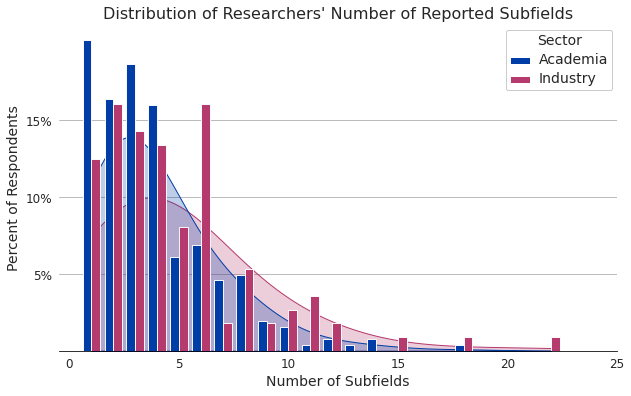

In [62]:
def plot_field_density(df, start_idx, end_idx):
    # Take the sum column-wise across all subfields to calculate the number of subfields selected by each academia
    acad = np.array(df.loc[df.Sector == 'Academia', df.columns[start_idx:end_idx]].fillna(0.).sum(axis = 1))
    # Drop results from academics who selected 0 subfields and print the median 
    acad = acad[np.nonzero(acad)]
    print('Median for academia:', np.median(acad))
    
    # Take the sum column-wise across all subfields to calculate the number of subfields selected by each industry researcher
    ind = np.array(df.loc[df.Sector == 'Industry', df.columns[start_idx:end_idx]].fillna(0.).sum(axis = 1))
    # Drop results from industry researchers who selected 0 subfields and print the median
    ind = ind[np.nonzero(ind)]
    print('Median for industry:', np.median(ind))
    
    # Create a dataframe of the data that can be passed to sns.kdeplot and sns.histplot
    data = pd.DataFrame({'count': np.concatenate((acad, ind)), 'Sector': ['Academia'] * len(acad) + ['Industry'] * len(ind)})
    
    # Create a figure, add kde plots and hist plots, and return the resulting objects
    fig, ax = plt.subplots(figsize=(10,6))
    gfg = sns.kdeplot(data = data, x = 'count', hue = 'Sector', bw_adjust = 2, fill = True,
               common_norm = False, clip = [1, np.max(data['count'])], palette = colors[:2], zorder = 1)
    gfg = sns.histplot(data, x = 'count', hue = 'Sector', discrete = True, stat = 'probability', common_norm = False, 
                 palette = colors[:2], multiple = 'dodge', shrink = 0.8, alpha = 1., zorder = 2)
    return ax, gfg


# Create the image: we care about items from "Image Recognition" (first low-level subfield) up to but NOT including "None of These"
ax, gfg = plot_field_density(df, df.columns.get_indexer(['ImageRecognition'])[0], df.columns.get_indexer(['NoneofThese'])[0])

# Apply a bunch of formatting 
ax.set_yticks([0.05, 0.1, 0.15])
ax.set_yticklabels(['5%', '10%', '15%'], fontname='DejaVu Sans', fontsize=12)
ax.set_ylabel('Percent of Respondents', fontname='DejaVu Sans', fontsize=14)
ax.set_xticks([0, 5, 10, 15, 20, 25])
ax.set_xticklabels(['0', '5', '10', '15', '20', '25'], fontsize=12, fontname='DejaVu Sans')
ax.set_xlabel('Number of Subfields', fontname='DejaVu Sans', fontsize=14)
ax.set_title('Distribution of Researchers\' Number of Reported Subfields', fontsize=16, fontname='DejaVu Sans')
plt.setp(gfg.get_legend().get_texts(), fontsize='14', fontname='DejaVu Sans') 
plt.setp(gfg.get_legend().get_title(), fontsize='14', fontname='DejaVu Sans')

plt.savefig('../results/figures/FigC1.jpg', dpi=300, bbox_inches='tight')

plt.show()
plt.close()

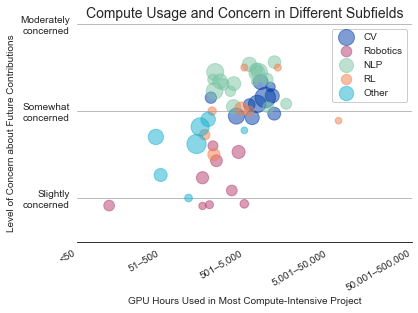

In [63]:
fig, ax = plt.subplots(figsize = (6, 4))

# Loop over each top-level field to calculate the average GPU-consumption and average concern for each subfield
for (i, field), subfields in zip(enumerate(fields), [cv_subfields, robotics_subfields, nlp_subfields, rl_subfields, other_subfields]):
    avg_gpus = []
    avg_concern = []
    n = []
    
    # For each subfield in the list corresponding to the high-level field then extract the relevant values and save them 
    for subfield in subfields:
        avg_gpus.append(df[df[subfield] == 1].CompGPUs.mean())
        avg_concern.append(df[df[subfield] == 1].ContributionConcern.mean())
        n.append(df[subfield].sum() * 5)  # Multiplying by five seems to make the resulting visualization best when passed to plt.scatter
        
    # Add the resulting data to the scatterplot
    ax.scatter(avg_gpus, avg_concern, s = n, c = colors[i], label = field, alpha = 0.5)

# Add a bunch of formatting
ax.set_xticks(range(1, 6))
ax.set_xticklabels(['<50', '51–500', '501–5,000', '5,001–50,000', '50,001–500,000'], rotation=30, ha='right')
ax.set_xlabel('GPU Hours Used in Most Compute-Intensive Project')
ax.set_yticks([0.5, 1, 2, 3])
ax.set_yticklabels(['', 'Slightly\nconcerned', 'Somewhat\nconcerned', 'Moderately\nconcerned'])
ax.set_ylabel('Level of Concern about Future Contributions')
ax.set_title('Compute Usage and Concern in Different Subfields')
ax.legend()

# Save the resulting image
plt.savefig(f'../results/figures/FigC2.jpg', dpi=300, bbox_inches='tight')

plt.show()
plt.close()

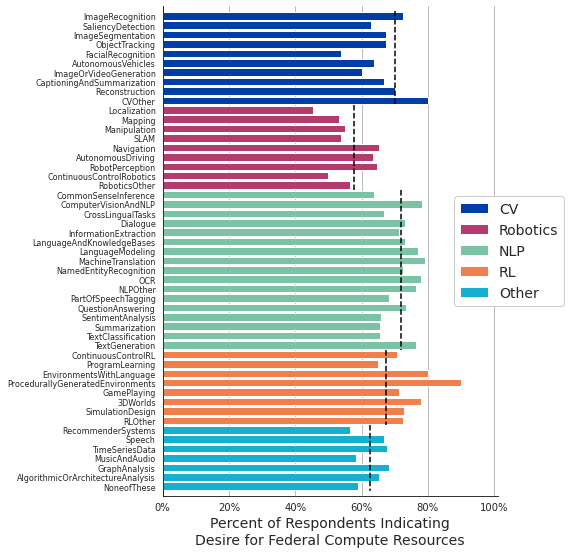

In [64]:
fig, ax = plt.subplots(figsize = (6, 9))

# Create arrays to track the proportion of each field (avg_props) and subfield (props) interested in NAIRR compute
props = []
avg_props = []
c = []

# Loop over each top-level field and calculate the proportion indicating desire for NAIRR compute
for (i, field), subfields in zip(enumerate(fields), [cv_subfields, robotics_subfields, nlp_subfields, rl_subfields, other_subfields]):
    avg_props.append(df[df[field] == 1].WantsCompute.mean())
    
    # Loop over each subfield and calculate the same, also store an appropriate color in an additional array
    for subfield in subfields:
        props.append(df[df[subfield] == 1].WantsCompute.mean())
        c.append(colors[i])

# For plotting with barh, we want to begin at n + 1, where n = num_subfields, and progressively plot subfields working downward to index 1
# So item n + 1 corresponds to item 0 in our list of props, item n corresponds to item 1, and so on
total_subfields = df.columns.get_indexer(['NoneofThese'])[0] - df.columns.get_indexer(['ImageRecognition'])[0]
cur_start_down = total_subfields + 1
cur_start_up = 0

# Loop over each top-level field, using barh to plot the proportions of all subfields in the right range of y-indices
for (i, field), subfields in zip(enumerate(fields), [cv_subfields, robotics_subfields, nlp_subfields, rl_subfields, other_subfields]):

    # Use barh to plot the proportions of all subfiels 
    ax.barh(range(cur_start_down, cur_start_down - len(subfields), -1), props[cur_start_up : cur_start_up + len(subfields)], color = colors[i], label = field)

    # Also plot a dashed black line above the relevant bars to show the average proportion across the whole top-level field
    ax.plot([avg_props[i]] * 2, [cur_start_down + 0.5, cur_start_down - len(subfields) + 0.5], 
            linestyle = '--', color = 'black')
    
    # Update the iterator variables 
    cur_start_up += len(subfields)
    cur_start_down -= len(subfields)

# Add legend, adjust aesthetics, add labels, and so on
ax.legend(loc='center left', bbox_to_anchor=(0.85, 0.5), prop=basefont)
ax.set_yticks(np.arange(total_subfields + 1, 0, step = -1))
ax.set_yticklabels(df.columns[df.columns.get_indexer(['ImageRecognition'])[0] : df.columns.get_indexer(['NoneofThese'])[0] + 1], fontsize=8, fontname='DejaVu Sans')
ax.set_ylim(0, total_subfields + 2)
ax.set_xlim(0, 1.01)
ax.set_xticks([0, 0.2, 0.4, 0.6, 0.8, 1.])
ax.set_xticklabels(['0%', '20%', '40%', '60%', '80%', '100%'], fontname='DejaVu Sans', fontsize=10)
ax.set_xlabel('Percent of Respondents Indicating\nDesire for Federal Compute Resources', fontsize=14, fontname='DejaVu Sans')
ax.grid(False)
ax.grid(axis='x')
ax.spines['left'].set_visible(True)

# Save result
plt.savefig('../results/figures/FigC3.jpg', dpi=300, bbox_inches='tight')

plt.show()
plt.close()